# PROYECTO POLISOMNOGRAMA
## CIENCIA DE DATOS EN BIOMEDICINA
### ÁNGEL GUEVARA Y ARTURO SIRVENT

In [269]:
# Módulos 

# Básicos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math

# Preprocesado
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Análisis sueño
import mne 
import yasa

# Modelado
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.inspection import permutation_importance

# Evaluación 
from sklearn.metrics import plot_roc_curve, classification_report, confusion_matrix

# Extracción de características
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


In [40]:
#vamos a meter todo en una función
def load_valid_data(file_dir,return_bool_vect=False):
    #en esta duncion añadimos automaticamente lo de eliminarlas ultimas 30!!
    #se cargan los datos del excel
    anotaciones_hypno1=pd.read_excel(file_dir)
    merge_aux=anotaciones_hypno1["Events"].astype("str")+ anotaciones_hypno1["HR"].astype("str")
    merge_aux=merge_aux.apply(str.strip,args=(["nan"]))
    numeros=[re.findall("[0-9]{2,3}",i)[0] for i in merge_aux]
    anotaciones=[re.findall("\D+",i) for i in merge_aux]
    #si está vacia le ponemos un 0 y en el resto -1 
    anotaciones1=[ -1 if i else 0 for i in anotaciones ]

    #tambien vamos a poner a -1 todas las anteriores a la que dice lights out por primera vez
    for i,j in enumerate(anotaciones):
        if "L Out" in [k.strip() for k in j]: #igual habria que mejor la forma en que busca el lights out, no se
            break
        elif i>20:
            print("igual algo pasa, no hay lights out")
        else:
            anotaciones1[i]=-1

    #de esta forma obtenemos todas las epocas no válidas, con un -1 
    #anotaciones1

    #para poner esto en una forma más accesible, podemos crear un 
    #vector booleano o uno que contenga los indices validos
    if return_bool_vect:
        bool_vect = np.array(anotaciones1)==0
        #aqui ponemos los ultimos 30 a False, como si tuviera anotaciones, no validos
        bool_vect[-30:]=False
        
        #devolvemos en True los que no tienen anotaciones
        return bool_vect
    
    else:
        indices_validos = np.array([i[0] for i in np.argwhere(np.array(anotaciones1[:-30])==0)])

        return indices_validos

## Leemos las señales y las preprocesamos

In [41]:
# Leemos los datos
raw_8 = mne.io.read_raw_edf('./raw_data/8/8.edf', preload=True)
raw_9 = mne.io.read_raw_edf('./raw_data/9/9.edf', preload=True)
raw_10 = mne.io.read_raw_edf('./raw_data/10/10.edf', preload=True)

Extracting EDF parameters from C:\Users\Usuario\MCD\CDB\Proyecto_Polisomnograma\raw_data\8\8.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999999  =      0.000 ... 29999.995 secs...
Extracting EDF parameters from C:\Users\Usuario\MCD\CDB\Proyecto_Polisomnograma\raw_data\9\9.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5813999  =      0.000 ... 29069.995 secs...
Extracting EDF parameters from C:\Users\Usuario\MCD\CDB\Proyecto_Polisomnograma\raw_data\10\10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4775999  =      0.000 ... 23879.995 secs...


In [42]:
# Nos quedamos solo con los canales que nos interesen 


print(raw_9.ch_names)

raw_8.drop_channels(['ROC-A1', 'F3-A2', 'O1-A2', 'F4-A1', 'C4-A1', 'O2-A1', 'X2', 'X3', 'X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 
                   'SaO2', 'DC8'])

raw_9.drop_channels(['ROC-A1', 'F3-A2', 'O1-A2', 'F4-A1', 'C4-A1', 'O2-A1', 'X2', 'X3', 'X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 
                   'SaO2', 'DC8'])

raw_10.drop_channels(['ROC-A1', 'F3-A2', 'O1-A2', 'F4-A1', 'C4-A1', 'O2-A1', 'X2', 'X3', 'X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 
                   'SaO2', 'DC8'])

['LOC-A2', 'ROC-A1', 'F3-A2', 'C3-A2', 'O1-A2', 'F4-A1', 'C4-A1', 'O2-A1', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 'SaO2', 'DC8']


<RawEDF | 10.edf, 3 x 4776000 (23880.0 s), ~109.3 MB, data loaded>

In [43]:
# Reducimos las muestras a la mitad haciendo un downsampling. Es decir, en vez de coger 200 tomas por segundo, cogeremos 100.
raw_8.resample(100)
sf8 = raw_8.info['sfreq']

raw_9.resample(100)
sf9 = raw_9.info['sfreq']

raw_10.resample(100)
sf10 = raw_10.info['sfreq']

In [44]:
# Además, aplicamos un filtro de pasa-banda porque las frecuencias de interés están en un rango de 0-30 aprox

raw_8.filter(0.3, 49.99)
raw_9.filter(0.3, 49.99)
raw_10.filter(0.3, 45)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 49.99 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 50.00 Hz)
- Filter length: 33001 samples (330.010 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passban

<RawEDF | 10.edf, 3 x 2388000 (23880.0 s), ~54.7 MB, data loaded>

In [45]:
# Podemos acceder a los datos de la siguiente manera

data8 = raw_8.get_data() * 1e6
print(data8.shape)

data9 = raw_9.get_data() * 1e6
print(data9.shape)

data10 = raw_10.get_data() * 1e6
print(data10.shape)

(3, 3000000)
(3, 2907000)
(3, 2388000)


In [46]:
# Quitamos las últimas 30 épocas, para ello, tenedremos que restar 30 épocas, de 30 segundos cada una, dónde 1 segundo son 100 
# tomas. 
# En resumen, quitamos las últimas 30*30*100 muestras.

ultimas_30 = 30*30*100

data8 = data8[:,0:-ultimas_30]

data9 = data9[:,0:-ultimas_30]

data10 = data10[:,0:-ultimas_30]


In [47]:
print(data8.shape)
print(data9.shape)
print(data10.shape)

(3, 2910000)
(3, 2817000)
(3, 2298000)


In [48]:
# Quitamos las últimas 30 épocas del objeto row también para que no haya problemas en las funciones espectrales que usaremos
# más adelante. 

raw_8.crop(0,data8.shape[1]/100, include_tmax = False)

raw_9.crop(0,data9.shape[1]/100, include_tmax = False)

raw_10.crop(0,data10.shape[1]/100, include_tmax = False)

<RawEDF | 10.edf, 3 x 2298000 (22980.0 s), ~52.6 MB, data loaded>

In [49]:
# Importamos las etiquetas de cada señal. Estas han sido puestas por dos expertos distintos que han estado en completa 
# concordancia. Se encuentran en los ficheros de texto correspondientes.


hypno8 = pd.read_csv("./raw_data/8/8_1.txt", squeeze=True, header=None)
hypno9 = pd.read_csv("./raw_data/9/9_1.txt", squeeze=True, header=None)
hypno10 = pd.read_csv("./raw_data/10/10_1.txt", squeeze=True, header=None)

#Las etiquetas vienen codificadas con los números 0,1,2,3,5
print(hypno8.unique())
print(hypno9.unique())
print(hypno10.unique())

[0 1 2 3 5]
[0 1 2 3 5]
[0 1 2 3 5]


<AxesSubplot:xlabel='Time [hrs]', ylabel='Stage'>

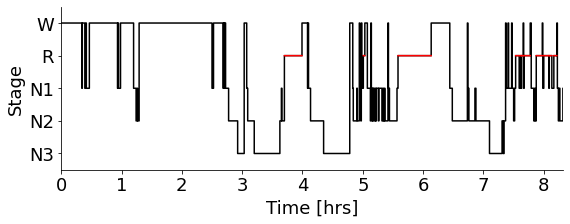

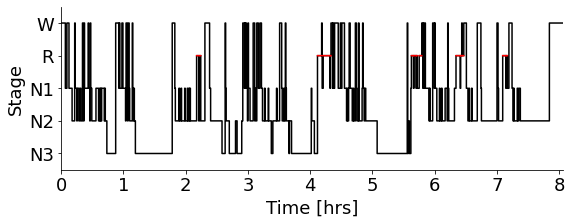

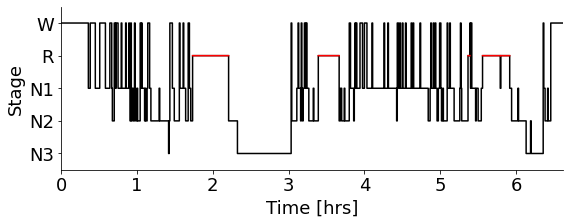

In [50]:
# Renombramos la clase 5 como clase 4 para que no de problemas las funciones. 

for i in range(hypno8.shape[0]):
    if hypno8.values[i]==5:
        hypno8.values[i]=4
        
for i in range(hypno9.shape[0]):
    if hypno9.values[i]==5:
        hypno9.values[i]=4
        
for i in range(hypno10.shape[0]):
    if hypno10.values[i]==5:
        hypno10.values[i]=4
        
        
# Los dibujamos
yasa.plot_hypnogram(hypno8)
yasa.plot_hypnogram(hypno9)
yasa.plot_hypnogram(hypno10)

In [51]:
# Recordemos que las etiquetas las teníamos en la variable `hypno`
# quitamos las últimas 30 épocas en cada caso ya que éstas no hay que tenerlas en cuenta.


# Sujeto 8
labels8 = hypno8[0:-30]
print(labels8.shape)

# Sujeto 9
labels9 = hypno9[0:-30]
print(labels9.shape)

# Sujeto 10
labels10 = hypno10[0:-30]
print(labels10.shape)

(970,)
(939,)
(766,)


In [52]:
# Nos quedamos solo con las etiquetas válidas, es decir, aquellas que no tienen ninguna anotación que pueda ser problemática.

# Sujeto 8
indices_8 = load_valid_data("./raw_data/8/8_1.xlsx",return_bool_vect=False)
labels8_validas = labels8[indices_8]

# Sujeto 9
indices_9 = load_valid_data("./raw_data/9/9_1.xlsx",return_bool_vect=False)
labels9_validas = labels9[indices_9]

# Sujeto 10
indices_10 = load_valid_data("./raw_data/10/10_1.xlsx",return_bool_vect=False)
labels10_validas = labels10[indices_10]

In [53]:
print(labels8.shape)

(970,)


## Troceamos en intervalos de 30 segundos. (REVISAR PORQUE CREO QUE NO LO USO AL FINAL)

In [13]:
# Sujeto 8
data8_2 = []
cortes8 = (data8.shape[1]/sf8) / 30

for i in range(data8.shape[0]):
        data8_2.append(np.split(data8[i], cortes8))

# Sujeto 9
data9_2 = []
cortes9 = (data9.shape[1]/sf9) / 30

for i in range(data9.shape[0]):
        data9_2.append(np.split(data9[i], cortes9))
        
# Sujeto 10
data10_2 = []
cortes10 = (data10.shape[1]/sf10) / 30

for i in range(data10.shape[0]):
        data10_2.append(np.split(data10[i], cortes10))

In [14]:
# Transformamos en array la lista con los cortes hechos

# Sujeto 8
data8_2 = np.array(data8_2)
print(data8_2.shape)

# Sujeto 9
data9_2 = np.array(data9_2)
print(data9_2.shape)

# Sujeto 10
data10_2 = np.array(data10_2)
print(data10_2.shape)

(3, 970, 3000)
(3, 939, 3000)
(3, 766, 3000)


## Extraemos características 

En una primera aproximación, sacaremos las medias y las desviaciones típicas de tramo de 30 segundos en cada canal.

C:\Users\Usuario\anaconda3\envs\MCD_21_22\lib\site-packages\sklearn\base.py:324: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


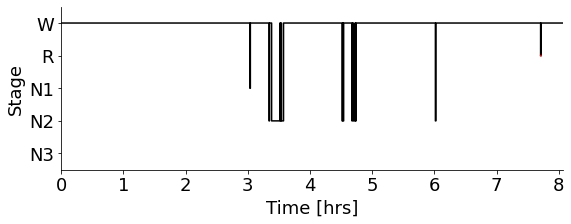

In [54]:
# Sujeto 8
sls8 = yasa.SleepStaging(raw_8, eeg_name='C3-A2', eog_name='LOC-A2', emg_name='X1')
hypno_pred8 = sls8.predict()  # Predict the sleep stages
hypno_pred8 = yasa.hypno_str_to_int(hypno_pred8)  # Convert "W" to 0, "N1" to 1, etc
yasa.plot_hypnogram(hypno_pred8); 

C:\Users\Usuario\anaconda3\envs\MCD_21_22\lib\site-packages\sklearn\base.py:324: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


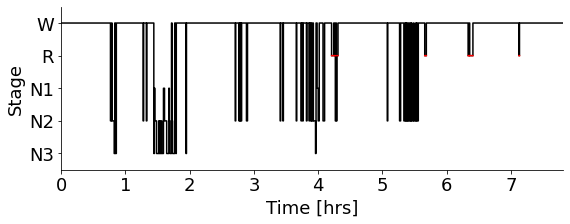

In [55]:
# Sujeto 9
sls9 = yasa.SleepStaging(raw_9, eeg_name='C3-A2', eog_name='LOC-A2', emg_name='X1')
hypno_pred9 = sls9.predict()  # Predict the sleep stages
hypno_pred9 = yasa.hypno_str_to_int(hypno_pred9)  # Convert "W" to 0, "N1" to 1, etc
yasa.plot_hypnogram(hypno_pred9); 

C:\Users\Usuario\anaconda3\envs\MCD_21_22\lib\site-packages\sklearn\base.py:324: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


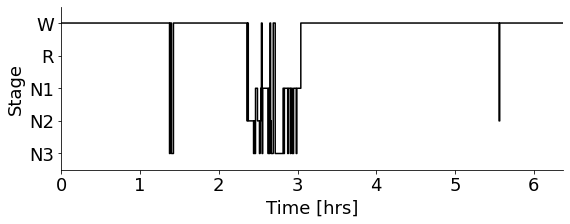

In [56]:
# Sujeto 10
sls10 = yasa.SleepStaging(raw_10, eeg_name='C3-A2', eog_name='LOC-A2', emg_name='X1')
hypno_pred10 = sls10.predict()  # Predict the sleep stages
hypno_pred10 = yasa.hypno_str_to_int(hypno_pred10)  # Convert "W" to 0, "N1" to 1, "N2" to 2, "N3" to 3 and REM to "4"
yasa.plot_hypnogram(hypno_pred10); 

In [57]:
# Extraemos características

# Sujeto 8
features_8 = sls8.get_features()
# Sujeto 9
features_9 = sls9.get_features()
# Sujeto 10
features_10 = sls10.get_features()

In [58]:
# Nos quedamos solo con las características de las muestras válidas. 
# Recordemos que tenemos los índices guardados de celdas anteriores.

features_8_validas = features_8.iloc[indices_8,]

features_9_validas = features_9.iloc[indices_9,]

features_10_validas = features_10.iloc[indices_10,]

In [59]:
features_8_validas

,eeg_abspow,eeg_abspow_c7min_norm,eeg_abspow_p2min_norm,eeg_alpha,eeg_alpha_c7min_norm,eeg_alpha_p2min_norm,eeg_at,eeg_at_c7min_norm,eeg_at_p2min_norm,eeg_beta,...,eog_skew_c7min_norm,eog_skew_p2min_norm,eog_std,eog_std_c7min_norm,eog_std_p2min_norm,eog_theta,eog_theta_c7min_norm,eog_theta_p2min_norm,time_hour,time_norm
epoch,,,,,,,,,,,,,,,,,,,,,
1,5.240892,0.912996,1.436574,0.262013,0.455877,0.234352,3.482800,0.645939,0.476353,0.261714,...,-0.564484,-0.430728,4.236856,1.121821,2.210652,0.061887,-0.612157,-0.597417,0.008333,0.001032
4,3.164528,0.743629,0.694412,0.431922,0.519175,0.426598,5.049477,0.675600,0.568981,0.271876,...,-0.581902,-0.548754,1.826683,0.764979,0.928076,0.077217,-0.593656,-0.576455,0.033333,0.004128
5,4.136151,0.699118,0.510622,0.509817,0.535527,0.546724,7.197478,0.678086,0.721075,0.220385,...,-0.573987,-0.589859,2.007484,0.675440,0.404659,0.067857,-0.586411,-0.566482,0.041667,0.005160
6,3.458320,0.636555,0.578018,0.516499,0.549762,0.625812,5.805417,0.672804,0.812905,0.217947,...,-0.564392,-0.599877,1.839040,0.593759,0.326706,0.067775,-0.577427,-0.572207,0.050000,0.006192
7,3.780870,0.565480,0.599328,0.450488,0.554411,0.625366,4.986484,0.655540,0.820175,0.215742,...,-0.548328,-0.560838,2.218993,0.519758,0.228028,0.079574,-0.563208,-0.537433,0.058333,0.007224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
965,2.297324,-0.177384,-0.195025,0.159416,-0.022214,-0.029946,0.965867,-0.011093,-0.011365,0.246440,...,0.282269,0.041927,2.299645,0.165806,0.278790,0.138692,0.156989,0.009874,8.041667,0.995872
966,2.625368,-0.175691,-0.206395,0.155437,-0.022868,-0.021721,0.677207,-0.011653,-0.010807,0.253879,...,0.318626,0.142642,1.703428,0.160056,0.202415,0.171430,0.159250,-0.001860,8.050000,0.996904
967,2.702834,-0.171998,-0.173341,0.146006,-0.024636,-0.019809,0.621968,-0.012488,-0.010523,0.250021,...,0.338902,0.309921,1.816432,0.162425,0.187248,0.183805,0.166044,0.064889,8.058333,0.997936


In [60]:
features_9_validas

,eeg_abspow,eeg_abspow_c7min_norm,eeg_abspow_p2min_norm,eeg_alpha,eeg_alpha_c7min_norm,eeg_alpha_p2min_norm,eeg_at,eeg_at_c7min_norm,eeg_at_p2min_norm,eeg_beta,...,eog_skew_c7min_norm,eog_skew_p2min_norm,eog_std,eog_std_c7min_norm,eog_std_p2min_norm,eog_theta,eog_theta_c7min_norm,eog_theta_p2min_norm,time_hour,time_norm
epoch,,,,,,,,,,,,,,,,,,,,,
4,1.859047,-0.100567,-0.080404,0.174524,0.697243,0.819033,1.309697,1.129465,1.172752,0.296029,...,-0.154348,-0.115706,1.580510,0.204462,0.264139,0.113959,-0.440698,-0.441449,0.033333,0.004264
5,1.977357,-0.102992,-0.104002,0.166582,0.660356,0.862454,1.203833,1.068003,1.273848,0.303667,...,-0.134520,-0.042048,1.570408,0.154629,-0.129238,0.090591,-0.450745,-0.351654,0.041667,0.005330
6,2.360058,-0.103993,-0.092835,0.135883,0.622743,0.661956,0.992478,1.011844,0.895000,0.310482,...,-0.123082,0.033286,1.520833,0.124464,-0.136405,0.110123,-0.464249,-0.300162,0.050000,0.006397
7,2.344649,-0.105226,-0.104576,0.216418,0.586671,0.696930,1.666781,0.962717,1.000788,0.326734,...,-0.128644,0.063881,1.635408,0.107006,-0.191716,0.094337,-0.479232,-0.306759,0.058333,0.007463
8,1.825706,-0.107002,-0.106020,0.177213,0.537890,0.703215,1.140345,0.892906,0.940256,0.350589,...,-0.133799,0.024919,1.621816,0.093484,-0.181381,0.074325,-0.487936,-0.395587,0.066667,0.008529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933,2.748768,0.071010,0.027748,0.116109,-0.069590,-0.035383,0.631722,-0.082396,-0.082264,0.098614,...,0.235475,0.387483,1.672283,-0.056312,-0.123011,0.209698,0.273493,0.279488,7.775000,0.994669
934,3.215868,0.079294,0.046847,0.072652,-0.085750,-0.080221,0.488856,-0.095791,-0.049009,0.102038,...,0.202259,0.281474,1.793841,-0.035141,-0.103586,0.170654,0.258794,0.299283,7.783333,0.995736
935,3.348229,0.088305,0.042951,0.091021,-0.099223,-0.025130,0.643512,-0.102956,0.015782,0.105900,...,0.173266,0.192724,1.929023,-0.015118,-0.032934,0.119026,0.240071,0.265505,7.791667,0.996802


In [62]:
print(classification_report(labels9_validas, hypno_pred9[indices_9]))

              precision    recall  f1-score   support

           0       0.17      0.99      0.29       116
           1       0.00      0.00      0.00        96
           2       0.02      0.00      0.01       308
           3       0.93      0.12      0.21       217
           4       0.88      0.26      0.41        57

    accuracy                           0.20       794
   macro avg       0.40      0.28      0.18       794
weighted avg       0.35      0.20      0.13       794



In [63]:
# Unimos los dos dataframes de características en uno solo


#X = X8.append(X9)
#X.reset_index(inplace=True, drop=True)
#X

X= features_8_validas.append(features_9_validas)
X.reset_index(inplace=True, drop=True)
X

,eeg_abspow,eeg_abspow_c7min_norm,eeg_abspow_p2min_norm,eeg_alpha,eeg_alpha_c7min_norm,eeg_alpha_p2min_norm,eeg_at,eeg_at_c7min_norm,eeg_at_p2min_norm,eeg_beta,...,eog_skew_c7min_norm,eog_skew_p2min_norm,eog_std,eog_std_c7min_norm,eog_std_p2min_norm,eog_theta,eog_theta_c7min_norm,eog_theta_p2min_norm,time_hour,time_norm
0,5.240892,0.912996,1.436574,0.262013,0.455877,0.234352,3.482800,0.645939,0.476353,0.261714,...,-0.564484,-0.430728,4.236856,1.121821,2.210652,0.061887,-0.612157,-0.597417,0.008333,0.001032
1,3.164528,0.743629,0.694412,0.431922,0.519175,0.426598,5.049477,0.675600,0.568981,0.271876,...,-0.581902,-0.548754,1.826683,0.764979,0.928076,0.077217,-0.593656,-0.576455,0.033333,0.004128
2,4.136151,0.699118,0.510622,0.509817,0.535527,0.546724,7.197478,0.678086,0.721075,0.220385,...,-0.573987,-0.589859,2.007484,0.675440,0.404659,0.067857,-0.586411,-0.566482,0.041667,0.005160
3,3.458320,0.636555,0.578018,0.516499,0.549762,0.625812,5.805417,0.672804,0.812905,0.217947,...,-0.564392,-0.599877,1.839040,0.593759,0.326706,0.067775,-0.577427,-0.572207,0.050000,0.006192
4,3.780870,0.565480,0.599328,0.450488,0.554411,0.625366,4.986484,0.655540,0.820175,0.215742,...,-0.548328,-0.560838,2.218993,0.519758,0.228028,0.079574,-0.563208,-0.537433,0.058333,0.007224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553,2.748768,0.071010,0.027748,0.116109,-0.069590,-0.035383,0.631722,-0.082396,-0.082264,0.098614,...,0.235475,0.387483,1.672283,-0.056312,-0.123011,0.209698,0.273493,0.279488,7.775000,0.994669
1554,3.215868,0.079294,0.046847,0.072652,-0.085750,-0.080221,0.488856,-0.095791,-0.049009,0.102038,...,0.202259,0.281474,1.793841,-0.035141,-0.103586,0.170654,0.258794,0.299283,7.783333,0.995736
1555,3.348229,0.088305,0.042951,0.091021,-0.099223,-0.025130,0.643512,-0.102956,0.015782,0.105900,...,0.173266,0.192724,1.929023,-0.015118,-0.032934,0.119026,0.240071,0.265505,7.791667,0.996802
1556,3.571526,0.097398,0.083532,0.057302,-0.114480,-0.135716,0.358100,-0.116491,-0.089600,0.087399,...,0.142119,0.057820,1.846464,0.002999,0.042097,0.137828,0.235847,0.204676,7.800000,0.997868


In [64]:
print(np.array(X.columns))

['eeg_abspow' 'eeg_abspow_c7min_norm' 'eeg_abspow_p2min_norm' 'eeg_alpha'
 'eeg_alpha_c7min_norm' 'eeg_alpha_p2min_norm' 'eeg_at'
 'eeg_at_c7min_norm' 'eeg_at_p2min_norm' 'eeg_beta' 'eeg_beta_c7min_norm'
 'eeg_beta_p2min_norm' 'eeg_db' 'eeg_db_c7min_norm' 'eeg_db_p2min_norm'
 'eeg_ds' 'eeg_ds_c7min_norm' 'eeg_ds_p2min_norm' 'eeg_dt'
 'eeg_dt_c7min_norm' 'eeg_dt_p2min_norm' 'eeg_fdelta'
 'eeg_fdelta_c7min_norm' 'eeg_fdelta_p2min_norm' 'eeg_hcomp'
 'eeg_hcomp_c7min_norm' 'eeg_hcomp_p2min_norm' 'eeg_higuchi'
 'eeg_higuchi_c7min_norm' 'eeg_higuchi_p2min_norm' 'eeg_hmob'
 'eeg_hmob_c7min_norm' 'eeg_hmob_p2min_norm' 'eeg_iqr'
 'eeg_iqr_c7min_norm' 'eeg_iqr_p2min_norm' 'eeg_kurt'
 'eeg_kurt_c7min_norm' 'eeg_kurt_p2min_norm' 'eeg_nzc'
 'eeg_nzc_c7min_norm' 'eeg_nzc_p2min_norm' 'eeg_perm'
 'eeg_perm_c7min_norm' 'eeg_perm_p2min_norm' 'eeg_petrosian'
 'eeg_petrosian_c7min_norm' 'eeg_petrosian_p2min_norm' 'eeg_sdelta'
 'eeg_sdelta_c7min_norm' 'eeg_sdelta_p2min_norm' 'eeg_sigma'
 'eeg_sigma_c7min_n

In [67]:
# Unimos también las etiquetas 

labels_validas= labels8_validas.append(labels9_validas)
labels_validas.reset_index(inplace=True, drop=True)
labels_validas

0       0
1       0
2       0
3       0
4       0
       ..
1553    2
1554    2
1555    2
1556    2
1557    2
Name: 0, Length: 1558, dtype: int64

In [41]:
# Probamos a obtener características adicionales a las que nos proporciona el etiquetado automático

# Antes necesitamos hacer un upsample sobre las frecuencias
#labels9_up = yasa.hypno_upsample_to_data(labels9, sf_hypno=1/30, data=raw_9)

#spindles = yasa.spindles_detect(raw_9, hypno=labels9_up, include=(2,3))

In [40]:
# Probamos a detectar las ondas lentas a ver si funciona

onda_lenta = yasa.sw_detect(raw_8, hypno=labels8_up, include=(2, 3))

31-May-22 10:57:41 | WARNING | No SW were found in channel LOC-A2.
31-May-22 10:57:41 | WARNING | No SW were found in channel C3-A2.
31-May-22 10:57:41 | WARNING | No SW were found in channel X1.
31-May-22 10:57:41 | WARNING | No SW were found in data. Returning None.


## Entrenamiento del modelo

In [68]:
# Dividimos en train y test 

x_train, x_test, y_train, y_test = train_test_split(X, labels_validas, test_size=0.2, random_state=0)


In [69]:
# Hacemos un Random Forest con las medias de cada tramo de cada canal

# Buscamos los parámetros óptimos del clasificador 

RF = OneVsRestClassifier(RandomForestClassifier(random_state=0))
#params = {'n_estimators': [], 'criterion': ['gini', 'entropy'], 'max_depth':[1,2,3,4,5,6,7]}

#RF = GridSearchCV(, param_grid=
RF.fit(x_train, y_train)

preds = RF.predict(x_test)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       105
           1       0.56      0.40      0.47        25
           2       0.85      0.94      0.90        86
           3       0.93      0.98      0.95        53
           4       0.90      0.88      0.89        43

    accuracy                           0.89       312
   macro avg       0.84      0.83      0.83       312
weighted avg       0.89      0.89      0.89       312



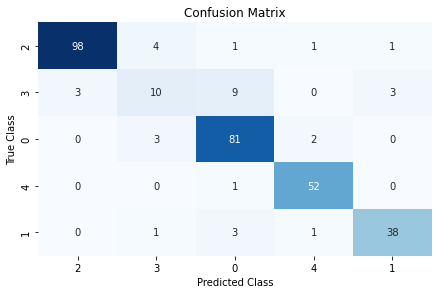

In [70]:
# Matriz de confusión 

matrix = confusion_matrix(y_test, preds)

dataframe = pd.DataFrame(matrix, index=y_test.unique(), columns=y_test.unique())

# crear mapa de calor dibujar mapa de calor
sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

C:\Users\Usuario\anaconda3\envs\MCD_21_22\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Usuario\anaconda3\envs\MCD_21_22\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Usuario\anaconda3\envs\MCD_21_22\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.fr

Text(0.5, 1.0, 'Estimador 5')

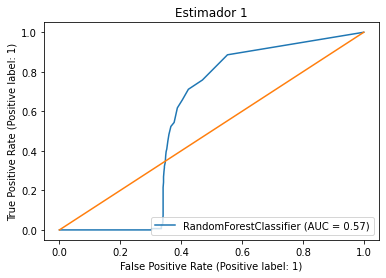

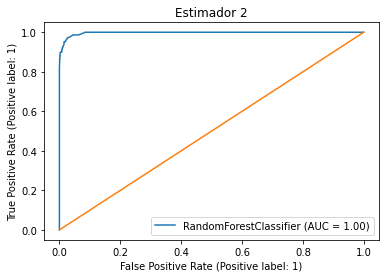

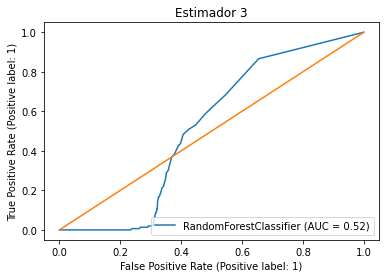

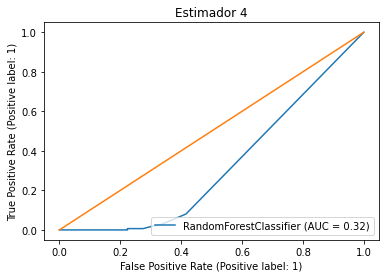

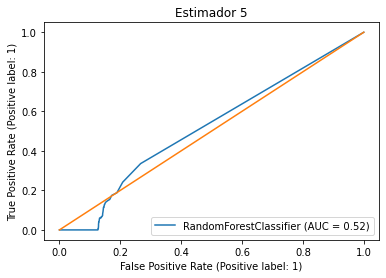

In [72]:
# Hacemos la curva ROC de cada uno de los 5 RandomForests creados para el conjunto de entrenamiento

plot_roc_curve(RF.estimators_[0], X, labels_validas )
plt.plot([0,1],[0,1])
plt.title('Estimador 1')

plot_roc_curve(RF.estimators_[1], X, labels_validas )
plt.plot([0,1],[0,1])
plt.title('Estimador 2')

plot_roc_curve(RF.estimators_[2], X, labels_validas )
plt.plot([0,1],[0,1])
plt.title('Estimador 3')

plot_roc_curve(RF.estimators_[3], X, labels_validas )
plt.plot([0,1],[0,1])
plt.title('Estimador 4')

plot_roc_curve(RF.estimators_[4], X, labels_validas )
plt.plot([0,1],[0,1])
plt.title('Estimador 5')

## Reducción de la dimensionalidad con importancia de características

In [73]:
# Hacemos un ranking de características para ver las más importantes. 
# Hay dos opciones: o bien hacerlo sobre el OneVsRest o hacer las características de cada uno de los cinco árboles y ver 
# cuáles son más importantes para cada uno de ellos. 

permutation_importance(RF, x_train, y_train)

# Parece que no funciona muy bien

{'importances_mean': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'importances_std': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

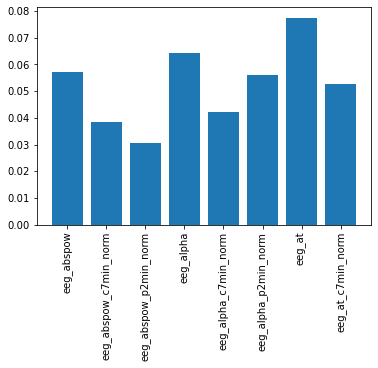

In [74]:
# Uno a uno 
# Primer clasificador 
importancias_0 = RF.estimators_[0].feature_importances_
importancias_0 = importancias_0[np.where(abs(importancias_0)>0.03)]
importancias_0_names = x_train.columns[np.where(abs(importancias_0)>0.03)]
#importancias_1_names = importancias_1_names[np.where(abs(importancias_1)>0.03)]
plt.bar(range(len(importancias_0)),importancias_0)
plt.xticks(ticks=range(len(importancias_0)),labels=importancias_0_names,rotation=90);

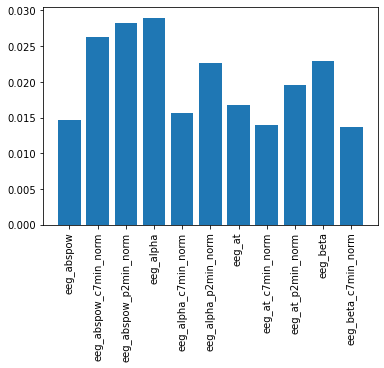

In [75]:
# Uno a uno 
# Segundo clasificador 
importancias_1 = RF.estimators_[1].feature_importances_
importancias_1 = importancias_1[np.where(abs(importancias_1)>0.013)]
importancias_1_names = x_train.columns[np.where(abs(importancias_1)>0.013)]
#importancias_1_names = importancias_1_names[np.where(abs(importancias_1)>0.03)]
plt.bar(range(len(importancias_1)),importancias_1)
plt.xticks(ticks=range(len(importancias_1)),labels=importancias_1_names,rotation=90);

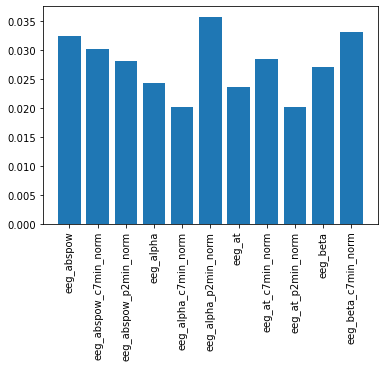

In [76]:
# Uno a uno 
# Tercer clasificador 
importancias_2 = RF.estimators_[2].feature_importances_
importancias_2 = importancias_2[np.where(abs(importancias_2)>0.02)]
importancias_2_names = x_train.columns[np.where(abs(importancias_2)>0.02)]
#importancias_1_names = importancias_1_names[np.where(abs(importancias_1)>0.03)]
plt.bar(range(len(importancias_2)),importancias_2)
plt.xticks(ticks=range(len(importancias_2)),labels=importancias_2_names,rotation=90);

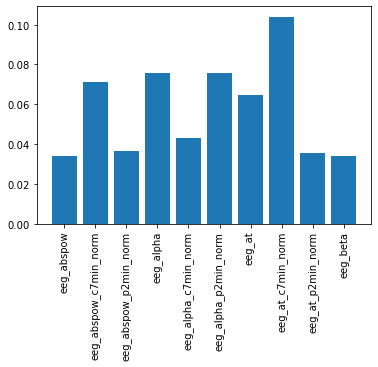

In [77]:
# Uno a uno 
# Cuarto clasificador 
importancias_3 = RF.estimators_[3].feature_importances_
importancias_3 = importancias_3[np.where(abs(importancias_3)>0.03)]
importancias_3_names = x_train.columns[np.where(abs(importancias_3)>0.03)]
#importancias_1_names = importancias_1_names[np.where(abs(importancias_1)>0.03)]
plt.bar(range(len(importancias_3)),importancias_3)
plt.xticks(ticks=range(len(importancias_3)),labels=importancias_3_names,rotation=90);

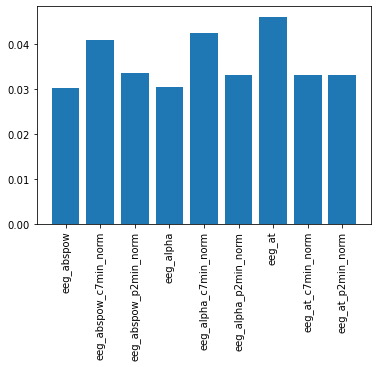

In [78]:
# Uno a uno 
# Quinto clasificador 
importancias_4 = RF.estimators_[4].feature_importances_
importancias_4 = importancias_4[np.where(abs(importancias_4)>0.03)]
importancias_4_names = x_train.columns[np.where(abs(importancias_4)>0.03)]
#importancias_1_names = importancias_1_names[np.where(abs(importancias_1)>0.03)]
plt.bar(range(len(importancias_4)),importancias_4)
plt.xticks(ticks=range(len(importancias_4)),labels=importancias_4_names,rotation=90);

In [79]:
# Vamos a quedarnos con el conjunto de características que son importantes para nuestros 5 random Forest y volvemos a entrenar 
# con eso a ver que pasa.

#set(importancias_0_names + importancias_1_names + importancias_2_names + importancias_3_names + importancias_4_names)

importancias_names = importancias_0_names.append(importancias_1_names)
importancias_names.append(importancias_2_names)
importancias_names.append(importancias_3_names)
importancias_names.append(importancias_4_names) 
                                            
importancias_names = set(importancias_names)
importancias_names


{'eeg_abspow',
 'eeg_abspow_c7min_norm',
 'eeg_abspow_p2min_norm',
 'eeg_alpha',
 'eeg_alpha_c7min_norm',
 'eeg_alpha_p2min_norm',
 'eeg_at',
 'eeg_at_c7min_norm',
 'eeg_at_p2min_norm',
 'eeg_beta',
 'eeg_beta_c7min_norm'}

In [80]:
# Probamos a entrenar solo con dichas características que eran las más relevantes.

X2 = X[importancias_names]
X2

,eeg_at,eeg_beta_c7min_norm,eeg_alpha_p2min_norm,eeg_abspow_p2min_norm,eeg_abspow,eeg_alpha_c7min_norm,eeg_beta,eeg_at_c7min_norm,eeg_at_p2min_norm,eeg_alpha,eeg_abspow_c7min_norm
0,3.482800,0.474109,0.234352,1.436574,5.240892,0.455877,0.261714,0.645939,0.476353,0.262013,0.912996
1,5.049477,0.378202,0.426598,0.694412,3.164528,0.519175,0.271876,0.675600,0.568981,0.431922,0.743629
2,7.197478,0.338218,0.546724,0.510622,4.136151,0.535527,0.220385,0.678086,0.721075,0.509817,0.699118
3,5.805417,0.296026,0.625812,0.578018,3.458320,0.549762,0.217947,0.672804,0.812905,0.516499,0.636555
4,4.986484,0.262984,0.625366,0.599328,3.780870,0.554411,0.215742,0.655540,0.820175,0.450488,0.565480
...,...,...,...,...,...,...,...,...,...,...,...
1553,0.631722,-0.210647,-0.035383,0.027748,2.748768,-0.069590,0.098614,-0.082396,-0.082264,0.116109,0.071010
1554,0.488856,-0.220940,-0.080221,0.046847,3.215868,-0.085750,0.102038,-0.095791,-0.049009,0.072652,0.079294
1555,0.643512,-0.230895,-0.025130,0.042951,3.348229,-0.099223,0.105900,-0.102956,0.015782,0.091021,0.088305
1556,0.358100,-0.240897,-0.135716,0.083532,3.571526,-0.114480,0.087399,-0.116491,-0.089600,0.057302,0.097398


In [82]:
# Dividimos en train y test 

x2_train, x2_test, y2_train, y2_test = train_test_split(X2, labels_validas, test_size=0.2, random_state=0)


In [107]:
# Hacemos un Random Forest con las medias de cada tramo de cada canal

# Buscamos los parámetros óptimos del clasificador 

RF2 = OneVsRestClassifier(RandomForestClassifier(random_state=0))
#params = {'n_estimators': [], 'criterion': ['gini', 'entropy'], 'max_depth':[1,2,3,4,5,6,7]}

#RF = GridSearchCV(, param_grid=
RF2.fit(x2_train, y2_train)

preds2 = RF2.predict(x2_test)

print(classification_report(y2_test, preds2))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       105
           1       0.56      0.36      0.44        25
           2       0.75      0.90      0.82        86
           3       0.89      0.96      0.93        53
           4       0.85      0.67      0.75        43

    accuracy                           0.84       312
   macro avg       0.80      0.76      0.77       312
weighted avg       0.84      0.84      0.83       312



C:\Users\Usuario\anaconda3\envs\MCD_21_22\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Usuario\anaconda3\envs\MCD_21_22\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Usuario\anaconda3\envs\MCD_21_22\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.fr

Text(0.5, 1.0, 'Estimador 5')

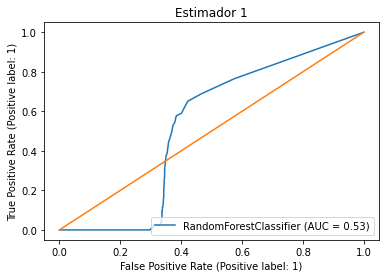

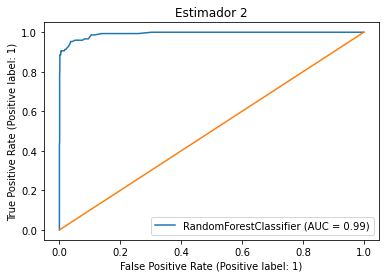

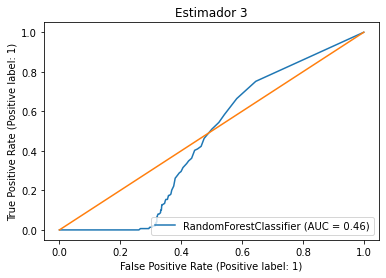

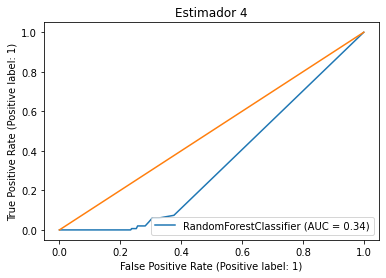

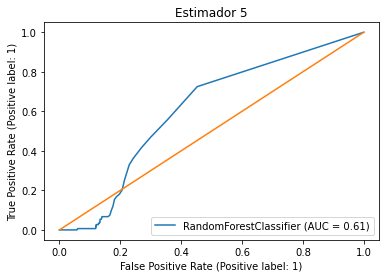

In [85]:
# Hacemos la curva ROC de cada uno de los 5 RandomForests creados para el conjunto de entrenamiento

plot_roc_curve(RF2.estimators_[0], X2, labels_validas )
plt.plot([0,1],[0,1])
plt.title('Estimador 1')

plot_roc_curve(RF2.estimators_[1], X2, labels_validas )
plt.plot([0,1],[0,1])
plt.title('Estimador 2')

plot_roc_curve(RF2.estimators_[2], X2, labels_validas )
plt.plot([0,1],[0,1])
plt.title('Estimador 3')

plot_roc_curve(RF2.estimators_[3], X2, labels_validas )
plt.plot([0,1],[0,1])
plt.title('Estimador 4')

plot_roc_curve(RF2.estimators_[4], X2, labels_validas )
plt.plot([0,1],[0,1])
plt.title('Estimador 5')

## Reducción de la dimensionalidad con LDA

Probamos también a hacer una extracción de características con el método LDA, que procura hacer la reducción de la dimensionalidad resaltando las características más discriminatorias del conjunto de datos. Por tanto, es un buen método de cara a la clasificación. 

In [167]:
# Antes tenemos que normalizar los datos

scale=MinMaxScaler()
X_norm=scale.fit_transform(X)


In [161]:
np.min(X_norm[344])

0.009840212806206148

In [135]:
# Utilizamos una transformación recomendada por el profesor

#X_norm_2 = np.sign(X_norm)*np.arcsin(np.sqrt(np.abs(X_norm)))

In [168]:
# LDA

lda=LDA(n_components=4)
X_lda=lda.fit_transform(X_norm,labels_validas)

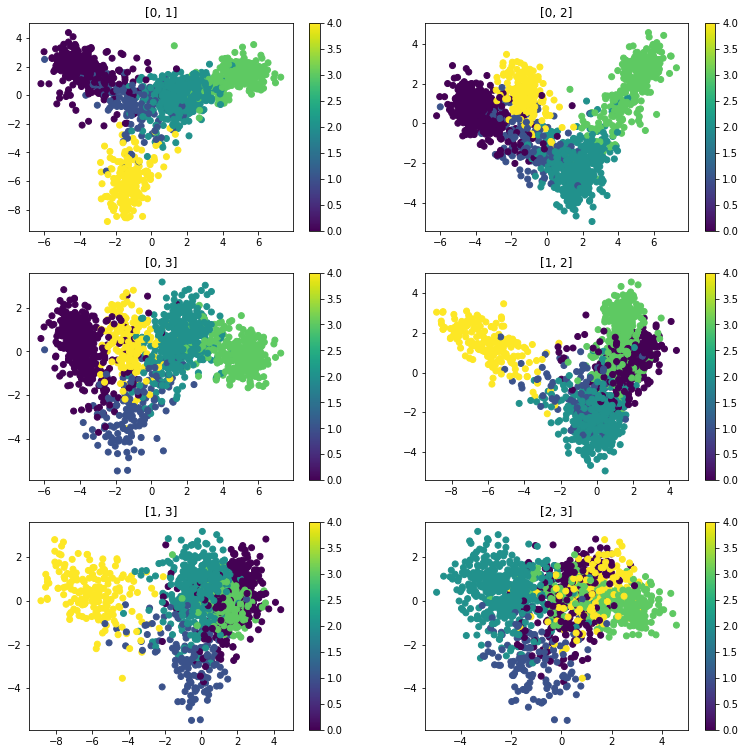

In [169]:
# Representación para ver si se separan bien las clases

plt.figure(figsize=(13,13))
combinaciones=[[0,1],[0,2],[0,3],[1,2],[1,3],[2,3]]
for i in range(6):
    plt.subplot(3,2,i+1)
    plt.scatter(X_lda[:,combinaciones[i][0]],X_lda[:,combinaciones[i][1]],c=labels_validas)
    plt.title(combinaciones[i])
    plt.colorbar()

In [170]:
# Ahora vemos que tal funciona el modelo con los datos reducidos mediante LDA.

# Dividimos en train y test 

x3_train, x3_test, y3_train, y3_test = train_test_split(X_lda, labels_validas, test_size=0.2, random_state=0)

In [171]:
# Hacemos un Random Forest con las medias de cada tramo de cada canal

# Buscamos los parámetros óptimos del clasificador 

RF3 = OneVsRestClassifier(RandomForestClassifier(random_state=0))
#params = {'n_estimators': [], 'criterion': ['gini', 'entropy'], 'max_depth':[1,2,3,4,5,6,7]}

#RF = GridSearchCV(, param_grid=
RF3.fit(x3_train, y3_train)

preds3 = RF3.predict(x3_test)

print(classification_report(y3_test, preds3))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       105
           1       0.63      0.76      0.69        25
           2       0.93      0.94      0.94        86
           3       0.98      0.98      0.98        53
           4       0.97      0.91      0.94        43

    accuracy                           0.93       312
   macro avg       0.90      0.91      0.90       312
weighted avg       0.94      0.93      0.93       312



C:\Users\Usuario\anaconda3\envs\MCD_21_22\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Usuario\anaconda3\envs\MCD_21_22\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Usuario\anaconda3\envs\MCD_21_22\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.fr

Text(0.5, 1.0, 'Estimador 5')

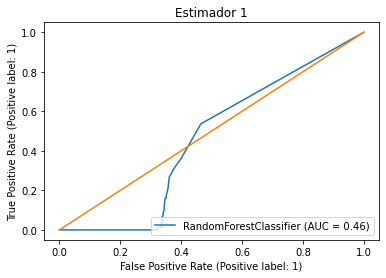

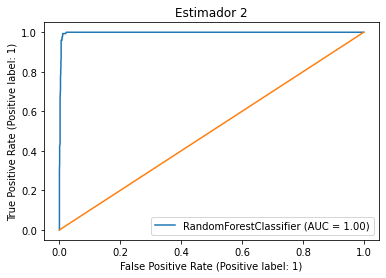

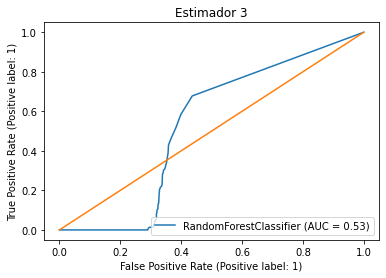

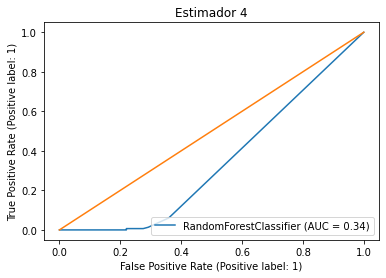

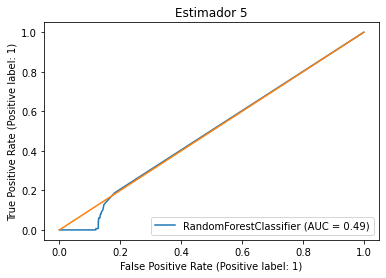

In [172]:
# Hacemos la curva ROC de cada uno de los 5 RandomForests creados para el conjunto de entrenamiento

plot_roc_curve(RF3.estimators_[0], X_lda, labels_validas )
plt.plot([0,1],[0,1])
plt.title('Estimador 1')

plot_roc_curve(RF3.estimators_[1], X_lda, labels_validas )
plt.plot([0,1],[0,1])
plt.title('Estimador 2')

plot_roc_curve(RF3.estimators_[2], X_lda, labels_validas )
plt.plot([0,1],[0,1])
plt.title('Estimador 3')

plot_roc_curve(RF3.estimators_[3], X_lda, labels_validas )
plt.plot([0,1],[0,1])
plt.title('Estimador 4')

plot_roc_curve(RF3.estimators_[4], X_lda, labels_validas )
plt.plot([0,1],[0,1])
plt.title('Estimador 5')

Una vez entreando el modelo, hacemos las predicciones sobre el sujeto 10. Este sujeto nunca lo ha visto nuestro modelo.

In [87]:
preds_10 = RF.predict(features_10_validas)
print(classification_report(labels10_validas, preds_10))

              precision    recall  f1-score   support

           0       0.60      1.00      0.75       117
           1       0.67      0.30      0.41       121
           2       0.66      0.80      0.72       122
           3       0.94      0.89      0.92       111
           4       0.98      0.74      0.84       133

    accuracy                           0.74       604
   macro avg       0.77      0.75      0.73       604
weighted avg       0.77      0.74      0.73       604



C:\Users\Usuario\anaconda3\envs\MCD_21_22\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Usuario\anaconda3\envs\MCD_21_22\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Usuario\anaconda3\envs\MCD_21_22\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.fr

Text(0.5, 1.0, 'Estimador 5')

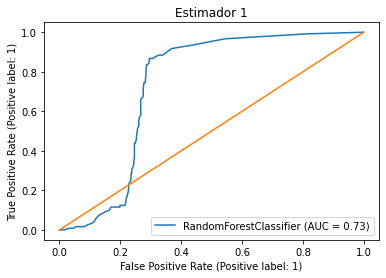

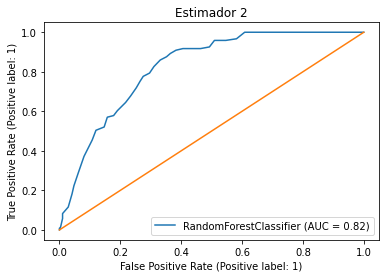

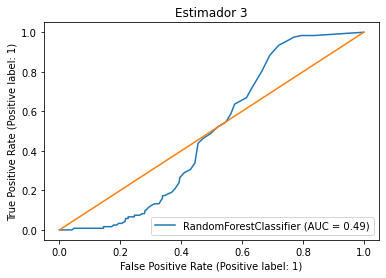

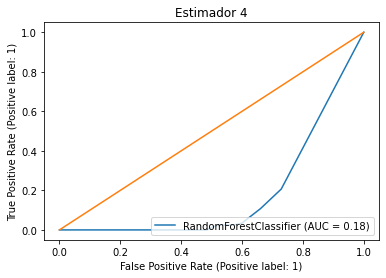

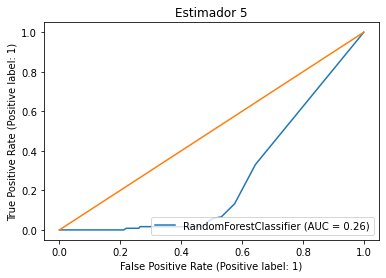

In [89]:
# Hacemos la curva ROC de cada uno de los 5 RandomForests creados. 

plot_roc_curve(RF.estimators_[0], features_10_validas, labels10_validas )
plt.plot([0,1],[0,1])
plt.title('Estimador 1')

plot_roc_curve(RF.estimators_[1], features_10_validas, labels10_validas )
plt.plot([0,1],[0,1])
plt.title('Estimador 2')

plot_roc_curve(RF.estimators_[2], features_10_validas, labels10_validas )
plt.plot([0,1],[0,1])
plt.title('Estimador 3')

plot_roc_curve(RF.estimators_[3], features_10_validas, labels10_validas )
plt.plot([0,1],[0,1])
plt.title('Estimador 4')

plot_roc_curve(RF.estimators_[4], features_10_validas, labels10_validas )
plt.plot([0,1],[0,1])
plt.title('Estimador 5')

In [90]:
# Probamos a estimar con el RandomForest solo con las características más importantes

preds2_10 = RF2.predict(features_10_validas[importancias_names])
print(classification_report(labels10_validas, preds2_10))

              precision    recall  f1-score   support

           0       0.60      0.74      0.66       117
           1       0.55      0.30      0.39       121
           2       0.40      0.84      0.54       122
           3       0.95      0.91      0.93       111
           4       0.53      0.13      0.21       133

    accuracy                           0.57       604
   macro avg       0.61      0.58      0.54       604
weighted avg       0.60      0.57      0.53       604



Vemos como el rendimiento general baja bastante al considerar menos características. 

C:\Users\Usuario\anaconda3\envs\MCD_21_22\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Usuario\anaconda3\envs\MCD_21_22\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Usuario\anaconda3\envs\MCD_21_22\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.fr

Text(0.5, 1.0, 'Estimador 5')

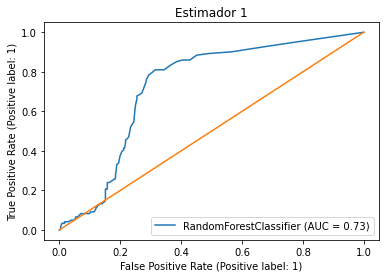

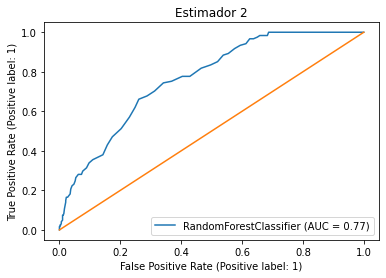

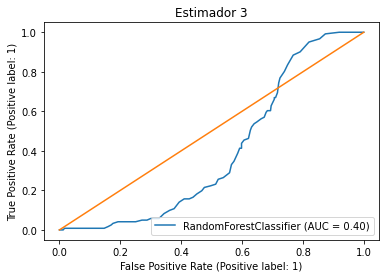

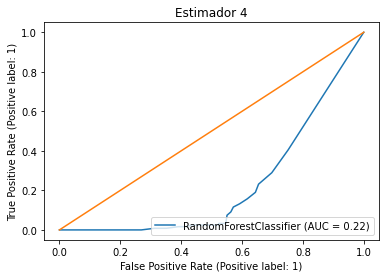

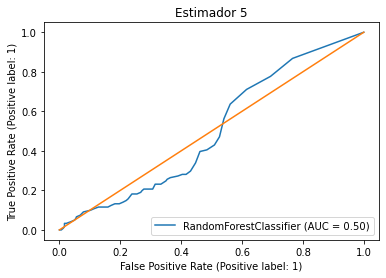

In [91]:
# Hacemos la curva ROC de cada uno de los 5 RandomForests creados. 

plot_roc_curve(RF2.estimators_[0], features_10_validas[importancias_names], labels10_validas )
plt.plot([0,1],[0,1])
plt.title('Estimador 1')

plot_roc_curve(RF2.estimators_[1], features_10_validas[importancias_names], labels10_validas )
plt.plot([0,1],[0,1])
plt.title('Estimador 2')

plot_roc_curve(RF2.estimators_[2], features_10_validas[importancias_names], labels10_validas )
plt.plot([0,1],[0,1])
plt.title('Estimador 3')

plot_roc_curve(RF2.estimators_[3], features_10_validas[importancias_names], labels10_validas )
plt.plot([0,1],[0,1])
plt.title('Estimador 4')

plot_roc_curve(RF2.estimators_[4], features_10_validas[importancias_names], labels10_validas )
plt.plot([0,1],[0,1])
plt.title('Estimador 5')

Sin embargo en test, parece que hemos mejorado algunas curvas ROC, como por ejemplo la encargada de detectar la clase 4, aunque también hemos empeorado algunas como las encargadas de las clases 0 y 1.

Puede parecer que no vamos mal, pero justamente en la clase 4 que parecía que mejoraba, estamos detectando muy pocos casos de todos los que hay. No creo que la curva ROC en este caso sea un resultado muy real.

Deberíamos añadir algunas características adicionales que tengan sentido clínico. Por ejemplo, las ondas beta, delta y theta.

In [102]:
print(np.array(X.columns))

['eeg_abspow' 'eeg_abspow_c7min_norm' 'eeg_abspow_p2min_norm' 'eeg_alpha'
 'eeg_alpha_c7min_norm' 'eeg_alpha_p2min_norm' 'eeg_at'
 'eeg_at_c7min_norm' 'eeg_at_p2min_norm' 'eeg_beta' 'eeg_beta_c7min_norm'
 'eeg_beta_p2min_norm' 'eeg_db' 'eeg_db_c7min_norm' 'eeg_db_p2min_norm'
 'eeg_ds' 'eeg_ds_c7min_norm' 'eeg_ds_p2min_norm' 'eeg_dt'
 'eeg_dt_c7min_norm' 'eeg_dt_p2min_norm' 'eeg_fdelta'
 'eeg_fdelta_c7min_norm' 'eeg_fdelta_p2min_norm' 'eeg_hcomp'
 'eeg_hcomp_c7min_norm' 'eeg_hcomp_p2min_norm' 'eeg_higuchi'
 'eeg_higuchi_c7min_norm' 'eeg_higuchi_p2min_norm' 'eeg_hmob'
 'eeg_hmob_c7min_norm' 'eeg_hmob_p2min_norm' 'eeg_iqr'
 'eeg_iqr_c7min_norm' 'eeg_iqr_p2min_norm' 'eeg_kurt'
 'eeg_kurt_c7min_norm' 'eeg_kurt_p2min_norm' 'eeg_nzc'
 'eeg_nzc_c7min_norm' 'eeg_nzc_p2min_norm' 'eeg_perm'
 'eeg_perm_c7min_norm' 'eeg_perm_p2min_norm' 'eeg_petrosian'
 'eeg_petrosian_c7min_norm' 'eeg_petrosian_p2min_norm' 'eeg_sdelta'
 'eeg_sdelta_c7min_norm' 'eeg_sdelta_p2min_norm' 'eeg_sigma'
 'eeg_sigma_c7min_n

In [111]:
importancias_names + set(['eeg_beta', 'eeg_delta', 'eeg_theta'])

TypeError: unsupported operand type(s) for +: 'set' and 'set'

In [109]:
importancias_names

{'eeg_abspow',
 'eeg_abspow_c7min_norm',
 'eeg_abspow_p2min_norm',
 'eeg_alpha',
 'eeg_alpha_c7min_norm',
 'eeg_alpha_p2min_norm',
 'eeg_at',
 'eeg_at_c7min_norm',
 'eeg_at_p2min_norm'}

In [165]:
# Probamos a predecir el sujeto 10 (no visto) con el modelo entrenado con las características reducidas con LDA (RF3)

# Primero tenemos que hacerle el mismo preprocesado que hemos hecho antes (normalizar + LDA)
# Normalización
features_10_validas_norm=scale.fit_transform(features_10_validas)

# Transformación previa
#features_10_validas_norm_2 = np.sign(features_10_validas_norm)*np.arcsin(np.sqrt(np.abs(features_10_validas_norm)))
#features_10_validas_norm_2[344][126] = 0

#LDA
X_10_lda=lda.fit_transform(features_10_validas_norm,labels10_validas)

In [166]:
preds3_10 = RF3.predict(X_10_lda)
print(classification_report(labels10_validas, preds3_10))

              precision    recall  f1-score   support

           0       0.56      0.98      0.72       117
           1       0.93      0.22      0.36       121
           2       0.86      0.93      0.90       122
           3       0.97      0.93      0.95       111
           4       0.98      0.98      0.98       133

    accuracy                           0.81       604
   macro avg       0.86      0.81      0.78       604
weighted avg       0.86      0.81      0.78       604



C:\Users\Usuario\anaconda3\envs\MCD_21_22\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Usuario\anaconda3\envs\MCD_21_22\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Usuario\anaconda3\envs\MCD_21_22\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.fr

Text(0.5, 1.0, 'Estimador 5')

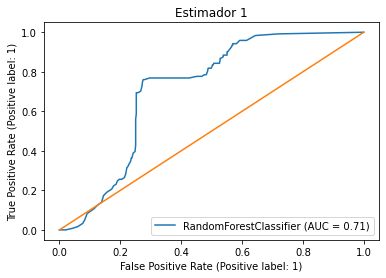

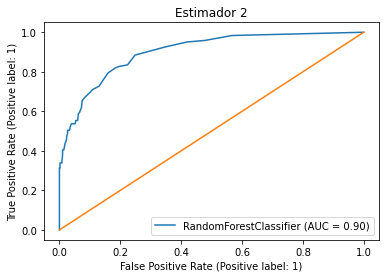

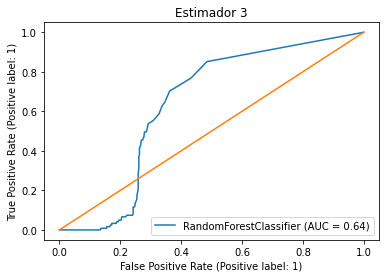

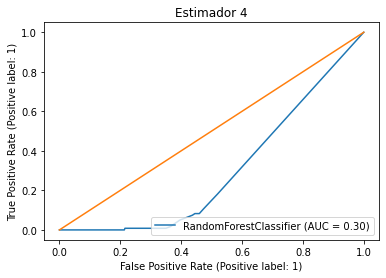

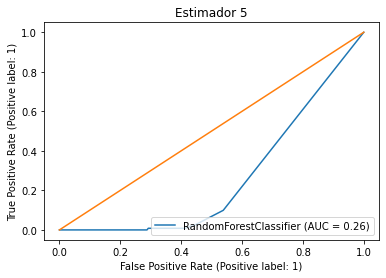

In [113]:
# Hacemos la curva ROC de cada uno de los 5 RandomForests creados. 

plot_roc_curve(RF3.estimators_[0], X_10_lda, labels10_validas )
plt.plot([0,1],[0,1])
plt.title('Estimador 1')

plot_roc_curve(RF3.estimators_[1], X_10_lda, labels10_validas )
plt.plot([0,1],[0,1])
plt.title('Estimador 2')

plot_roc_curve(RF3.estimators_[2], X_10_lda, labels10_validas )
plt.plot([0,1],[0,1])
plt.title('Estimador 3')

plot_roc_curve(RF3.estimators_[3], X_10_lda, labels10_validas )
plt.plot([0,1],[0,1])
plt.title('Estimador 4')

plot_roc_curve(RF3.estimators_[4], X_10_lda, labels10_validas )
plt.plot([0,1],[0,1])
plt.title('Estimador 5')

La LDA parece que funciona bastante bien, hasta ahora la que mejor resultados nos da. Lo malo es que perdemos interpretabilidad y los médicos nos dan por culo. 

## Probamos otra aproximación

Probamos una aproximación distinta. Ahora en vez de crear un modelo genérico, lo que vamos a hacer es simplemente intentar facilitar la tarea del etiquetado del análisis del sueño. No es una solución ideal (esta sería un etiquetado automático y que funcionase de maravilla), pero es mejor de lo que tienen ahora los médicos (etiquetado a mano, una pila de horas). 

Por tanto, lo que vamos a intentar es que para cada análisis del sueño, se etiquete el 30% de los datos y con eso entrenar un modelo específico de ese paciente y etiquetar de forma automática el 70% restante. 

In [174]:
# Sujeto 8 

# Cogemos las características válidas para el entrenamiento(features_8_validas) y las etiquetas válidas(labels8_validas)

# Divididimos eso en entrenamiento(30%) y test(70%)  
x4_train, x4_test, y4_train, y4_test = train_test_split(features_8_validas, labels8_validas, test_size=0.7, random_state=0)


# Normalizamos
scale=MinMaxScaler()
x4_train_norm=scale.fit_transform(x4_train)


# LDA
lda=LDA(n_components=4)
x4_train_lda=lda.fit_transform(x4_train_norm,y4_train)


In [176]:
# Modelo. RandomForest OneVsAll

# Buscamos los parámetros óptimos del clasificador 

RF4 = OneVsRestClassifier(RandomForestClassifier(random_state=0))
#params = {'n_estimators': [], 'criterion': ['gini', 'entropy'], 'max_depth':[1,2,3,4,5,6,7]}

#RF = GridSearchCV(, param_grid=
RF4.fit(x4_train_lda, y4_train)


# Normalizamos y aplicamos LDA sobre el conjunto de test 
x4_test_norm=scale.fit_transform(x4_test)
x4_test_lda=lda.fit_transform(x4_test_norm,y4_test)

# Predecimos
preds4 = RF4.predict(x4_test_lda)

print(classification_report(y4_test, preds4))


# Los resultados están bien 

              precision    recall  f1-score   support

           0       0.79      0.98      0.87       248
           1       0.47      0.97      0.64        39
           2       0.97      0.87      0.91        97
           3       0.00      0.00      0.00        63
           4       1.00      0.70      0.83        88

    accuracy                           0.80       535
   macro avg       0.65      0.70      0.65       535
weighted avg       0.74      0.80      0.75       535



C:\Users\Usuario\anaconda3\envs\MCD_21_22\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Usuario\anaconda3\envs\MCD_21_22\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Usuario\anaconda3\envs\MCD_21_22\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [177]:
# Sujeto 9 

# Cogemos las características válidas para el entrenamiento(features_8_validas) y las etiquetas válidas(labels8_validas)

# Divididimos eso en entrenamiento(30%) y test(70%)  
x9_train, x9_test, y9_train, y9_test = train_test_split(features_9_validas, labels9_validas, test_size=0.7, random_state=0)


# Normalizamos
scale=MinMaxScaler()
x9_train_norm=scale.fit_transform(x9_train)


# LDA
lda=LDA(n_components=4)
x9_train_lda=lda.fit_transform(x9_train_norm,y9_train)

In [186]:
# Modelo. RandomForest OneVsAll

# Buscamos los parámetros óptimos del clasificador 

RF9 = OneVsRestClassifier(RandomForestClassifier(random_state=0))
#params = {'n_estimators': [10,50,100,200,500,1000], 'criterion': ['gini', 'entropy'], 'max_depth':[1,2,3,4,5,6,7]}

#RF9_best = GridSearchCV(RF9, params)


In [187]:
RF9.fit(x9_train_lda, y9_train)


# Normalizamos y aplicamos LDA sobre el conjunto de test 
x9_test_norm=scale.fit_transform(x9_test)
x9_test_lda=lda.fit_transform(x9_test_norm,y9_test)

# Predecimos
preds9 = RF9.predict(x9_test_lda)

print(classification_report(y9_test, preds9))


# Los resultados están bien 

              precision    recall  f1-score   support

           0       0.98      0.79      0.88        81
           1       0.77      0.81      0.79        67
           2       0.86      0.99      0.92       224
           3       0.96      0.97      0.96       140
           4       1.00      0.52      0.69        44

    accuracy                           0.90       556
   macro avg       0.92      0.82      0.85       556
weighted avg       0.90      0.90      0.89       556



In [188]:
RF9.get_params()

{'estimator__bootstrap': True,
 'estimator__ccp_alpha': 0.0,
 'estimator__class_weight': None,
 'estimator__criterion': 'gini',
 'estimator__max_depth': None,
 'estimator__max_features': 'auto',
 'estimator__max_leaf_nodes': None,
 'estimator__max_samples': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 100,
 'estimator__n_jobs': None,
 'estimator__oob_score': False,
 'estimator__random_state': 0,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': RandomForestClassifier(random_state=0),
 'n_jobs': None}

In [189]:
# Sujeto 10 

# Cogemos las características válidas para el entrenamiento(features_8_validas) y las etiquetas válidas(labels8_validas)

# Divididimos eso en entrenamiento(30%) y test(70%)  
x10_train, x10_test, y10_train, y10_test = train_test_split(features_10_validas, labels10_validas, test_size=0.7, 
                                                            random_state=0)


# Normalizamos
scale=MinMaxScaler()
x10_train_norm=scale.fit_transform(x10_train)


# LDA
lda=LDA(n_components=4)
x10_train_lda=lda.fit_transform(x10_train_norm,y10_train)


In [190]:
# Modelo. RandomForest OneVsAll

# Buscamos los parámetros óptimos del clasificador 

RF10 = OneVsRestClassifier(RandomForestClassifier(random_state=0))
#params = {'n_estimators': [], 'criterion': ['gini', 'entropy'], 'max_depth':[1,2,3,4,5,6,7]}

#RF = GridSearchCV(, param_grid=
RF10.fit(x10_train_lda, y10_train)


# Normalizamos y aplicamos LDA sobre el conjunto de test 
x10_test_norm=scale.fit_transform(x10_test)
x10_test_lda=lda.fit_transform(x10_test_norm,y10_test)

# Predecimos
preds10 = RF10.predict(x10_test_lda)

print(classification_report(y10_test, preds10))


# Los resultados están bien 

              precision    recall  f1-score   support

           0       1.00      0.02      0.05        85
           1       0.40      0.56      0.47        85
           2       0.48      0.90      0.62        79
           3       0.52      0.41      0.46        76
           4       0.91      0.85      0.88        98

    accuracy                           0.56       423
   macro avg       0.66      0.55      0.49       423
weighted avg       0.67      0.56      0.50       423



## Modelo grande con los 10 pacientes (8 entrenamiento y 2 test)

In [205]:
# Leemos los datos
raw_1 = mne.io.read_raw_edf('./raw_data/1/1.edf', preload=True)
raw_2 = mne.io.read_raw_edf('./raw_data/2/2.edf', preload=True)
raw_3 = mne.io.read_raw_edf('./raw_data/3/3.edf', preload=True)
raw_4 = mne.io.read_raw_edf('./raw_data/4/4.edf', preload=True)
raw_5 = mne.io.read_raw_edf('./raw_data/5/5.edf', preload=True)
raw_6 = mne.io.read_raw_edf('./raw_data/6/6.edf', preload=True)
raw_7 = mne.io.read_raw_edf('./raw_data/7/7.edf', preload=True)
raw_8 = mne.io.read_raw_edf('./raw_data/8/8.edf', preload=True)
raw_9 = mne.io.read_raw_edf('./raw_data/9/9.edf', preload=True)
raw_10 = mne.io.read_raw_edf('./raw_data/10/10.edf', preload=True)

Extracting EDF parameters from C:\Users\Usuario\MCD\CDB\Proyecto_Polisomnograma\raw_data\1\1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5723999  =      0.000 ... 28619.995 secs...
Extracting EDF parameters from C:\Users\Usuario\MCD\CDB\Proyecto_Polisomnograma\raw_data\2\2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5645999  =      0.000 ... 28229.995 secs...
Extracting EDF parameters from C:\Users\Usuario\MCD\CDB\Proyecto_Polisomnograma\raw_data\3\3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4943999  =      0.000 ... 24719.995 secs...
Extracting EDF parameters from C:\Users\Usuario\MCD\CDB\Proyecto_Polisomnograma\raw_data\4\4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4763999  =      0.000 ... 23819.995 secs...
Extracting EDF parameters from C:\Us

In [206]:
# Nos quedamos solo con los canales que nos interesen 


print(raw_9.ch_names)

raw_1.drop_channels(['ROC-A1', 'F3-A2', 'O1-A2', 'F4-A1', 'C4-A1', 'O2-A1', 'X2', 'X3', 'X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 
                   'SaO2', 'DC8'])

raw_2.drop_channels(['ROC-A1', 'F3-A2', 'O1-A2', 'F4-A1', 'C4-A1', 'O2-A1', 'X2', 'X3', 'X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 
                   'SaO2', 'DC8'])

raw_3.drop_channels(['ROC-A1', 'F3-A2', 'O1-A2', 'F4-A1', 'C4-A1', 'O2-A1', 'X2', 'X3', 'X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 
                   'SaO2', 'DC8'])

raw_4.drop_channels(['ROC-A1', 'F3-A2', 'O1-A2', 'F4-A1', 'C4-A1', 'O2-A1', 'X2', 'X3', 'X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 
                   'SaO2', 'DC8'])

raw_5.drop_channels(['ROC-A1', 'F3-A2', 'O1-A2', 'F4-A1', 'C4-A1', 'O2-A1', 'X2', 'X3', 'X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 
                   'SaO2', 'DC8'])

raw_6.drop_channels(['ROC-A1', 'F3-A2', 'O1-A2', 'F4-A1', 'C4-A1', 'O2-A1', 'X2', 'X3', 'X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 
                   'SaO2', 'DC8'])

raw_7.drop_channels(['ROC-A1', 'F3-A2', 'O1-A2', 'F4-A1', 'C4-A1', 'O2-A1', 'X2', 'X3', 'X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 
                   'SaO2', 'DC8'])

raw_8.drop_channels(['ROC-A1', 'F3-A2', 'O1-A2', 'F4-A1', 'C4-A1', 'O2-A1', 'X2', 'X3', 'X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 
                   'SaO2', 'DC8'])

raw_9.drop_channels(['ROC-A1', 'F3-A2', 'O1-A2', 'F4-A1', 'C4-A1', 'O2-A1', 'X2', 'X3', 'X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 
                   'SaO2', 'DC8'])

raw_10.drop_channels(['ROC-A1', 'F3-A2', 'O1-A2', 'F4-A1', 'C4-A1', 'O2-A1', 'X2', 'X3', 'X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 
                   'SaO2', 'DC8'])

['LOC-A2', 'ROC-A1', 'F3-A2', 'C3-A2', 'O1-A2', 'F4-A1', 'C4-A1', 'O2-A1', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 'SaO2', 'DC8']


<RawEDF | 10.edf, 3 x 4776000 (23880.0 s), ~109.3 MB, data loaded>

In [207]:
# Reducimos las muestras a la mitad haciendo un downsampling. Es decir, en vez de coger 200 tomas por segundo, cogeremos 100.

raw_1.resample(100)
sf1 = raw_1.info['sfreq']

raw_2.resample(100)
sf2 = raw_2.info['sfreq']

raw_3.resample(100)
sf3 = raw_3.info['sfreq']

raw_4.resample(100)
sf4 = raw_4.info['sfreq']

raw_5.resample(100)
sf5 = raw_5.info['sfreq']

raw_6.resample(100)
sf6 = raw_6.info['sfreq']

raw_7.resample(100)
sf7 = raw_7.info['sfreq']

raw_8.resample(100)
sf8 = raw_8.info['sfreq']

raw_9.resample(100)
sf9 = raw_9.info['sfreq']

raw_10.resample(100)
sf10 = raw_10.info['sfreq']

In [208]:
# Además, aplicamos un filtro de pasa-banda porque las frecuencias de interés están en un rango de 0-30 aprox



raw_1.filter(0.3, 49.99)
raw_2.filter(0.3, 49.99)
raw_3.filter(0.3, 49.99)
raw_4.filter(0.3, 49.99)
raw_5.filter(0.3, 49.99)
raw_6.filter(0.3, 49.99)
raw_7.filter(0.3, 49.99)
raw_8.filter(0.3, 49.99)
raw_9.filter(0.3, 49.99)
raw_10.filter(0.3, 45)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 49.99 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 50.00 Hz)
- Filter length: 33001 samples (330.010 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passban

<RawEDF | 10.edf, 3 x 2388000 (23880.0 s), ~54.7 MB, data loaded>

In [209]:
# Podemos acceder a los datos de la siguiente manera

data1 = raw_1.get_data() * 1e6
print(data1.shape)

data2 = raw_2.get_data() * 1e6
print(data2.shape)

data3 = raw_3.get_data() * 1e6
print(data3.shape)

data4 = raw_4.get_data() * 1e6
print(data4.shape)

data5 = raw_5.get_data() * 1e6
print(data5.shape)

data6 = raw_6.get_data() * 1e6
print(data6.shape)

data7 = raw_7.get_data() * 1e6
print(data7.shape)

data8 = raw_8.get_data() * 1e6
print(data8.shape)

data9 = raw_9.get_data() * 1e6
print(data9.shape)

data10 = raw_10.get_data() * 1e6
print(data10.shape)

(3, 2862000)
(3, 2823000)
(3, 2472000)
(3, 2382000)
(3, 2832000)
(3, 2559000)
(3, 2442000)
(3, 3000000)
(3, 2907000)
(3, 2388000)


In [210]:
# Quitamos las últimas 30 épocas, para ello, tenedremos que restar 30 épocas, de 30 segundos cada una, dónde 1 segundo son 100 
# tomas. 
# En resumen, quitamos las últimas 30*30*100 muestras.

ultimas_30 = 30*30*100


data1 = data1[:,0:-ultimas_30]

data2 = data2[:,0:-ultimas_30]

data3 = data3[:,0:-ultimas_30]

data4 = data4[:,0:-ultimas_30]

data5 = data5[:,0:-ultimas_30]

data6 = data6[:,0:-ultimas_30]

data7 = data7[:,0:-ultimas_30]

data8 = data8[:,0:-ultimas_30]

data9 = data9[:,0:-ultimas_30]

data10 = data10[:,0:-ultimas_30]


In [211]:
print(data1.shape)
print(data2.shape)
print(data3.shape)
print(data4.shape)
print(data5.shape)
print(data6.shape)
print(data7.shape)
print(data8.shape)
print(data9.shape)
print(data10.shape)

(3, 2772000)
(3, 2733000)
(3, 2382000)
(3, 2292000)
(3, 2742000)
(3, 2469000)
(3, 2352000)
(3, 2910000)
(3, 2817000)
(3, 2298000)


In [212]:
# Quitamos las últimas 30 épocas del objeto row también para que no haya problemas en las funciones espectrales que usaremos
# más adelante. 

raw_1.crop(0,data1.shape[1]/100, include_tmax = False)

raw_2.crop(0,data2.shape[1]/100, include_tmax = False)

raw_3.crop(0,data3.shape[1]/100, include_tmax = False)

raw_4.crop(0,data4.shape[1]/100, include_tmax = False)

raw_5.crop(0,data5.shape[1]/100, include_tmax = False)

raw_6.crop(0,data6.shape[1]/100, include_tmax = False)

raw_7.crop(0,data7.shape[1]/100, include_tmax = False)

raw_8.crop(0,data8.shape[1]/100, include_tmax = False)

raw_9.crop(0,data9.shape[1]/100, include_tmax = False)

raw_10.crop(0,data10.shape[1]/100, include_tmax = False)

<RawEDF | 10.edf, 3 x 2298000 (22980.0 s), ~52.6 MB, data loaded>

In [214]:
# Importamos las etiquetas de cada señal. Estas han sido puestas por dos expertos distintos que han estado en completa 
# concordancia. Se encuentran en los ficheros de texto correspondientes.

hypno1 = pd.read_csv("./raw_data/1/1_1.txt", squeeze=True, header=None)
hypno2 = pd.read_csv("./raw_data/2/2_1.txt", squeeze=True, header=None)
hypno3 = pd.read_csv("./raw_data/3/3_1.txt", squeeze=True, header=None)
hypno4 = pd.read_csv("./raw_data/4/4_1.txt", squeeze=True, header=None)
hypno5 = pd.read_csv("./raw_data/5/5_1.txt", squeeze=True, header=None)
hypno6 = pd.read_csv("./raw_data/6/6_1.txt", squeeze=True, header=None)
hypno7 = pd.read_csv("./raw_data/7/7_1.txt", squeeze=True, header=None)
hypno8 = pd.read_csv("./raw_data/8/8_1.txt", squeeze=True, header=None)
hypno9 = pd.read_csv("./raw_data/9/9_1.txt", squeeze=True, header=None)
hypno10 = pd.read_csv("./raw_data/10/10_1.txt", squeeze=True, header=None)

#Las etiquetas vienen codificadas con los números 0,1,2,3,5
print(hypno8.unique())
print(hypno9.unique())
print(hypno10.unique())

[0 1 2 3 5]
[0 1 2 3 5]
[0 1 2 3 5]


<AxesSubplot:xlabel='Time [hrs]', ylabel='Stage'>

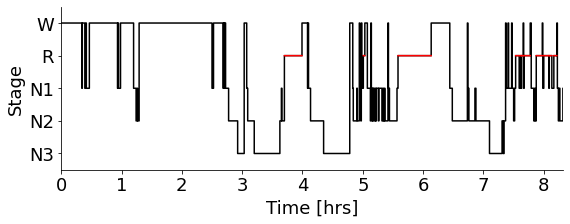

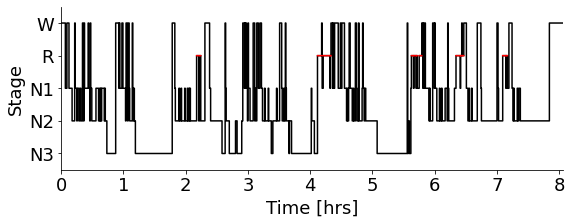

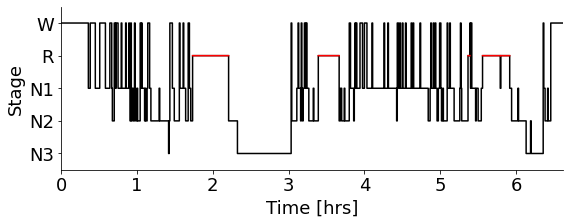

In [215]:
# Renombramos la clase 5 como clase 4 para que no de problemas las funciones. 

for i in range(hypno1.shape[0]):
    if hypno1.values[i]==5:
        hypno1.values[i]=4
        
for i in range(hypno2.shape[0]):
    if hypno2.values[i]==5:
        hypno2.values[i]=4
        
for i in range(hypno3.shape[0]):
    if hypno3.values[i]==5:
        hypno3.values[i]=4
        
for i in range(hypno4.shape[0]):
    if hypno4.values[i]==5:
        hypno4.values[i]=4
        
for i in range(hypno5.shape[0]):
    if hypno5.values[i]==5:
        hypno5.values[i]=4
        
for i in range(hypno6.shape[0]):
    if hypno6.values[i]==5:
        hypno6.values[i]=4

for i in range(hypno7.shape[0]):
    if hypno7.values[i]==5:
        hypno7.values[i]=4        

for i in range(hypno8.shape[0]):
    if hypno8.values[i]==5:
        hypno8.values[i]=4
        
for i in range(hypno9.shape[0]):
    if hypno9.values[i]==5:
        hypno9.values[i]=4
        
for i in range(hypno10.shape[0]):
    if hypno10.values[i]==5:
        hypno10.values[i]=4
        
        
# Los dibujamos
yasa.plot_hypnogram(hypno8)
yasa.plot_hypnogram(hypno9)
yasa.plot_hypnogram(hypno10)

In [216]:
# Recordemos que las etiquetas las teníamos en la variable `hypno`
# quitamos las últimas 30 épocas en cada caso ya que éstas no hay que tenerlas en cuenta.


# Sujeto 1
labels1 = hypno1[0:-30]
print(labels1.shape)

# Sujeto 2
labels2 = hypno2[0:-30]
print(labels2.shape)

# Sujeto 3
labels3 = hypno3[0:-30]
print(labels3.shape)

# Sujeto 4
labels4 = hypno4[0:-30]
print(labels4.shape)

# Sujeto 5
labels5 = hypno5[0:-30]
print(labels5.shape)

# Sujeto 6
labels6 = hypno6[0:-30]
print(labels6.shape)

# Sujeto 7
labels7 = hypno7[0:-30]
print(labels7.shape)

# Sujeto 8
labels8 = hypno8[0:-30]
print(labels8.shape)

# Sujeto 9
labels9 = hypno9[0:-30]
print(labels9.shape)

# Sujeto 10
labels10 = hypno10[0:-30]
print(labels10.shape)

(924,)
(911,)
(794,)
(764,)
(914,)
(823,)
(784,)
(970,)
(939,)
(766,)


In [217]:
# Nos quedamos solo con las etiquetas válidas, es decir, aquellas que no tienen ninguna anotación que pueda ser problemática.


# Sujeto 1
indices_1 = load_valid_data("./raw_data/1/1_1.xlsx",return_bool_vect=False)
labels1_validas = labels1[indices_1]

# Sujeto 2
indices_2 = load_valid_data("./raw_data/2/2_1.xlsx",return_bool_vect=False)
labels2_validas = labels2[indices_2]

# Sujeto 3
indices_3 = load_valid_data("./raw_data/3/3_1.xlsx",return_bool_vect=False)
labels3_validas = labels3[indices_3]


# Sujeto 4
indices_4 = load_valid_data("./raw_data/4/4_1.xlsx",return_bool_vect=False)
labels4_validas = labels4[indices_4]

# Sujeto 5
indices_5 = load_valid_data("./raw_data/5/5_1.xlsx",return_bool_vect=False)
labels5_validas = labels5[indices_5]

# Sujeto 6
indices_6 = load_valid_data("./raw_data/6/6_1.xlsx",return_bool_vect=False)
labels6_validas = labels6[indices_6]

# Sujeto 7
indices_7 = load_valid_data("./raw_data/7/7_1.xlsx",return_bool_vect=False)
labels7_validas = labels7[indices_7]

# Sujeto 8
indices_8 = load_valid_data("./raw_data/8/8_1.xlsx",return_bool_vect=False)
labels8_validas = labels8[indices_8]

# Sujeto 9
indices_9 = load_valid_data("./raw_data/9/9_1.xlsx",return_bool_vect=False)
labels9_validas = labels9[indices_9]

# Sujeto 10
indices_10 = load_valid_data("./raw_data/10/10_1.xlsx",return_bool_vect=False)
labels10_validas = labels10[indices_10]

Extraemos características de los pacientes de entrenamiento.

C:\Users\Usuario\anaconda3\envs\MCD_21_22\lib\site-packages\sklearn\base.py:324: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


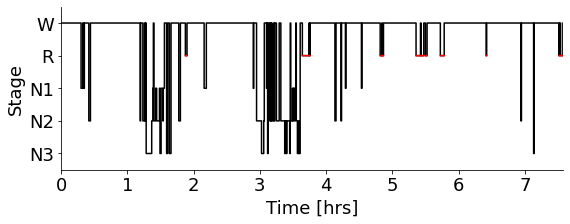

In [218]:
# Sujeto 2
sls2 = yasa.SleepStaging(raw_2, eeg_name='C3-A2', eog_name='LOC-A2', emg_name='X1')
hypno_pred2 = sls2.predict()  # Predict the sleep stages
hypno_pred2 = yasa.hypno_str_to_int(hypno_pred2)  # Convert "W" to 0, "N1" to 1, etc
yasa.plot_hypnogram(hypno_pred2); 

C:\Users\Usuario\anaconda3\envs\MCD_21_22\lib\site-packages\sklearn\base.py:324: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


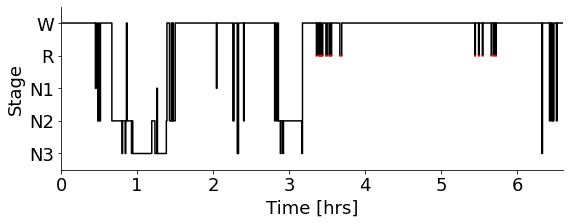

In [219]:
# Sujeto 3
sls3 = yasa.SleepStaging(raw_3, eeg_name='C3-A2', eog_name='LOC-A2', emg_name='X1')
hypno_pred3 = sls3.predict()  # Predict the sleep stages
hypno_pred3 = yasa.hypno_str_to_int(hypno_pred3)  # Convert "W" to 0, "N1" to 1, etc
yasa.plot_hypnogram(hypno_pred3); 

C:\Users\Usuario\anaconda3\envs\MCD_21_22\lib\site-packages\sklearn\base.py:324: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


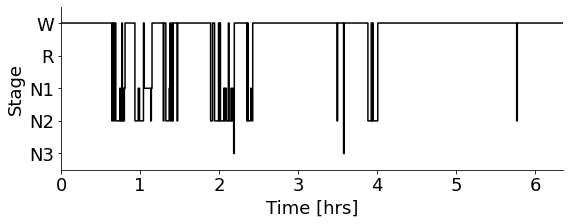

In [220]:
# Sujeto 4
sls4 = yasa.SleepStaging(raw_4, eeg_name='C3-A2', eog_name='LOC-A2', emg_name='X1')
hypno_pred4 = sls4.predict()  # Predict the sleep stages
hypno_pred4 = yasa.hypno_str_to_int(hypno_pred4)  # Convert "W" to 0, "N1" to 1, etc
yasa.plot_hypnogram(hypno_pred4); 

C:\Users\Usuario\anaconda3\envs\MCD_21_22\lib\site-packages\sklearn\base.py:324: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


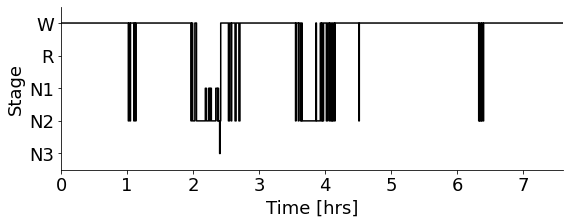

In [221]:
# Sujeto 5
sls5 = yasa.SleepStaging(raw_5, eeg_name='C3-A2', eog_name='LOC-A2', emg_name='X1')
hypno_pred5 = sls5.predict()  # Predict the sleep stages
hypno_pred5 = yasa.hypno_str_to_int(hypno_pred5)  # Convert "W" to 0, "N1" to 1, etc
yasa.plot_hypnogram(hypno_pred5); 

C:\Users\Usuario\anaconda3\envs\MCD_21_22\lib\site-packages\sklearn\base.py:324: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


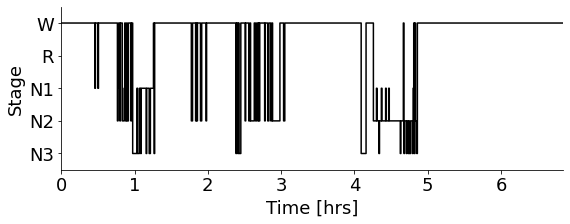

In [222]:
# Sujeto 6
sls6 = yasa.SleepStaging(raw_6, eeg_name='C3-A2', eog_name='LOC-A2', emg_name='X1')
hypno_pred6 = sls6.predict()  # Predict the sleep stages
hypno_pred6 = yasa.hypno_str_to_int(hypno_pred6)  # Convert "W" to 0, "N1" to 1, etc
yasa.plot_hypnogram(hypno_pred6); 

C:\Users\Usuario\anaconda3\envs\MCD_21_22\lib\site-packages\sklearn\base.py:324: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


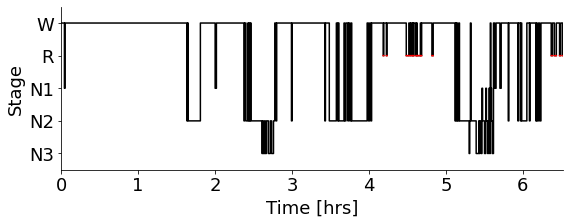

In [223]:
# Sujeto 7
sls7 = yasa.SleepStaging(raw_7, eeg_name='C3-A2', eog_name='LOC-A2', emg_name='X1')
hypno_pred7 = sls7.predict()  # Predict the sleep stages
hypno_pred7 = yasa.hypno_str_to_int(hypno_pred7)  # Convert "W" to 0, "N1" to 1, etc
yasa.plot_hypnogram(hypno_pred7); 

C:\Users\Usuario\anaconda3\envs\MCD_21_22\lib\site-packages\sklearn\base.py:324: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


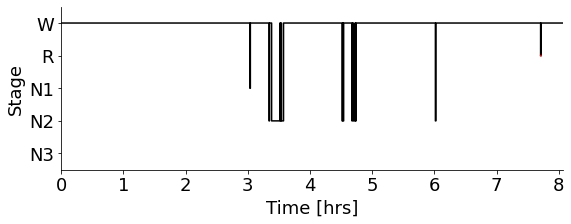

In [224]:
# Sujeto 8
sls8 = yasa.SleepStaging(raw_8, eeg_name='C3-A2', eog_name='LOC-A2', emg_name='X1')
hypno_pred8 = sls8.predict()  # Predict the sleep stages
hypno_pred8 = yasa.hypno_str_to_int(hypno_pred8)  # Convert "W" to 0, "N1" to 1, etc
yasa.plot_hypnogram(hypno_pred8); 

C:\Users\Usuario\anaconda3\envs\MCD_21_22\lib\site-packages\sklearn\base.py:324: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


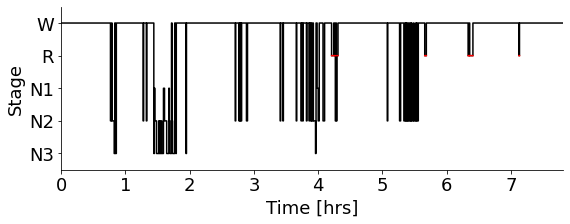

In [225]:
# Sujeto 9
sls9 = yasa.SleepStaging(raw_9, eeg_name='C3-A2', eog_name='LOC-A2', emg_name='X1')
hypno_pred9 = sls9.predict()  # Predict the sleep stages
hypno_pred9 = yasa.hypno_str_to_int(hypno_pred9)  # Convert "W" to 0, "N1" to 1, etc
yasa.plot_hypnogram(hypno_pred9); 

In [226]:
# Extraemos características


# Sujeto 2
features_2 = sls2.get_features()
# Sujeto 3
features_3 = sls3.get_features()
# Sujeto 4
features_4 = sls4.get_features()
# Sujeto 5
features_5 = sls5.get_features()
# Sujeto 6
features_6 = sls6.get_features()
# Sujeto 7
features_7 = sls7.get_features()
# Sujeto 8
features_8 = sls8.get_features()
# Sujeto 9
features_9 = sls9.get_features()

In [227]:
# Nos quedamos solo con las características de las muestras válidas. 
# Recordemos que tenemos los índices guardados de celdas anteriores.


features_2_validas = features_2.iloc[indices_2,]

features_3_validas = features_9.iloc[indices_3,]

features_4_validas = features_4.iloc[indices_4,]

features_5_validas = features_9.iloc[indices_5,]

features_6_validas = features_6.iloc[indices_6,]

features_7_validas = features_9.iloc[indices_7,]

features_8_validas = features_8.iloc[indices_8,]

features_9_validas = features_9.iloc[indices_9,]


In [228]:
X= features_2_validas.append(features_3_validas)
X.reset_index(inplace=True, drop=True)
X = X.append(features_4_validas)
X.reset_index(inplace=True, drop=True)
X = X.append(features_5_validas)
X.reset_index(inplace=True, drop=True)
X = X.append(features_6_validas)
X.reset_index(inplace=True, drop=True)
X = X.append(features_7_validas)
X.reset_index(inplace=True, drop=True)
X = X.append(features_8_validas)
X.reset_index(inplace=True, drop=True)
X = X.append(features_9_validas)
X.reset_index(inplace=True, drop=True)
X

,eeg_abspow,eeg_abspow_c7min_norm,eeg_abspow_p2min_norm,eeg_alpha,eeg_alpha_c7min_norm,eeg_alpha_p2min_norm,eeg_at,eeg_at_c7min_norm,eeg_at_p2min_norm,eeg_beta,...,eog_skew_c7min_norm,eog_skew_p2min_norm,eog_std,eog_std_c7min_norm,eog_std_p2min_norm,eog_theta,eog_theta_c7min_norm,eog_theta_p2min_norm,time_hour,time_norm
0,1.973582,-0.147424,-0.081585,0.165873,0.496688,0.932173,1.077612,0.738182,1.267328,0.380962,...,-0.388383,-0.332112,1.621270,-0.035563,0.296596,0.101835,-0.495903,-0.461777,0.016667,0.002198
1,1.966062,-0.148742,-0.112765,0.135891,0.388458,0.803624,0.924568,0.608527,1.066528,0.429200,...,-0.388796,-0.335191,1.588189,-0.090666,0.192883,0.095798,-0.493843,-0.455247,0.025000,0.003297
2,2.008532,-0.145865,-0.192393,0.112534,0.281028,0.577542,0.796362,0.487188,0.650950,0.453047,...,-0.389220,-0.287475,1.486755,-0.134482,-0.098210,0.100799,-0.495123,-0.414161,0.033333,0.004396
3,2.150398,-0.140506,-0.193376,0.118672,0.183586,0.391773,1.028887,0.377121,0.508159,0.453397,...,-0.391333,-0.305683,1.528943,-0.168365,-0.136632,0.074173,-0.497767,-0.461607,0.041667,0.005495
4,2.224462,-0.130641,-0.179533,0.065298,0.084941,0.143042,0.440558,0.259098,0.290970,0.404334,...,-0.386891,-0.323121,1.548022,-0.193821,-0.147180,0.077240,-0.492643,-0.521884,0.050000,0.006593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5603,2.748768,0.071010,0.027748,0.116109,-0.069590,-0.035383,0.631722,-0.082396,-0.082264,0.098614,...,0.235475,0.387483,1.672283,-0.056312,-0.123011,0.209698,0.273493,0.279488,7.775000,0.994669
5604,3.215868,0.079294,0.046847,0.072652,-0.085750,-0.080221,0.488856,-0.095791,-0.049009,0.102038,...,0.202259,0.281474,1.793841,-0.035141,-0.103586,0.170654,0.258794,0.299283,7.783333,0.995736
5605,3.348229,0.088305,0.042951,0.091021,-0.099223,-0.025130,0.643512,-0.102956,0.015782,0.105900,...,0.173266,0.192724,1.929023,-0.015118,-0.032934,0.119026,0.240071,0.265505,7.791667,0.996802
5606,3.571526,0.097398,0.083532,0.057302,-0.114480,-0.135716,0.358100,-0.116491,-0.089600,0.087399,...,0.142119,0.057820,1.846464,0.002999,0.042097,0.137828,0.235847,0.204676,7.800000,0.997868


In [230]:
# Unimos también las etiquetas 

labels_validas= labels2_validas.append(labels3_validas)
labels_validas.reset_index(inplace=True, drop=True)
labels_validas= labels_validas.append(labels4_validas)
labels_validas.reset_index(inplace=True, drop=True)
labels_validas= labels_validas.append(labels5_validas)
labels_validas.reset_index(inplace=True, drop=True)
labels_validas= labels_validas.append(labels6_validas)
labels_validas.reset_index(inplace=True, drop=True)
labels_validas= labels_validas.append(labels7_validas)
labels_validas.reset_index(inplace=True, drop=True)
labels_validas= labels_validas.append(labels9_validas)
labels_validas.reset_index(inplace=True, drop=True)
labels_validas= labels_validas.append(labels8_validas)
labels_validas.reset_index(inplace=True, drop=True)
labels_validas

0       0
1       0
2       0
3       0
4       0
       ..
5603    4
5604    4
5605    4
5606    4
5607    4
Name: 0, Length: 5608, dtype: int64

Ahora extraemos características con LDA, igual que antes.

In [231]:
# Antes tenemos que normalizar los datos

scale=MinMaxScaler()
X_norm=scale.fit_transform(X)

In [232]:
# LDA

lda=LDA(n_components=4)
X_lda=lda.fit_transform(X_norm,labels_validas)

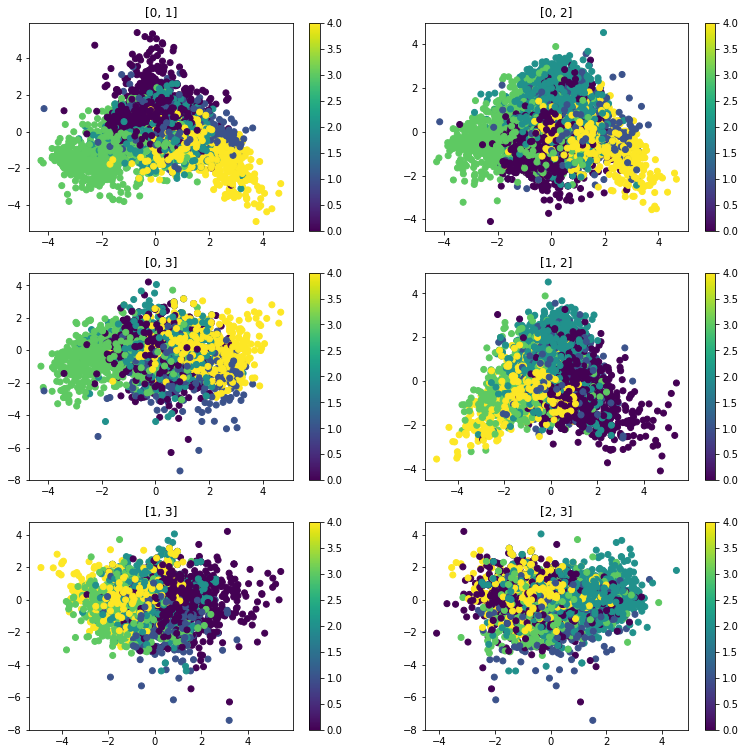

In [233]:
# Representación para ver si se separan bien las clases

plt.figure(figsize=(13,13))
combinaciones=[[0,1],[0,2],[0,3],[1,2],[1,3],[2,3]]
for i in range(6):
    plt.subplot(3,2,i+1)
    plt.scatter(X_lda[:,combinaciones[i][0]],X_lda[:,combinaciones[i][1]],c=labels_validas)
    plt.title(combinaciones[i])
    plt.colorbar()

In [234]:
# Ahora vemos que tal funciona el modelo con los datos reducidos mediante LDA.

# Dividimos en train y test 

x_train, x_test, y_train, y_test = train_test_split(X_lda, labels_validas, test_size=0.2, random_state=0)

In [257]:
# Hacemos un Random Forest con las medias de cada tramo de cada canal

# Empezamos con los parámetros por defecto 

RF = OneVsRestClassifier(RandomForestClassifier(random_state=0))

RF.fit(x_train, y_train)

preds = RF.predict(x_test)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.46      0.45      0.45       262
           1       0.31      0.21      0.25        75
           2       0.52      0.54      0.53       319
           3       0.53      0.55      0.54       330
           4       0.45      0.47      0.46       136

    accuracy                           0.49      1122
   macro avg       0.45      0.44      0.45      1122
weighted avg       0.48      0.49      0.49      1122



In [258]:
RF.get_params().keys()

dict_keys(['estimator__bootstrap', 'estimator__ccp_alpha', 'estimator__class_weight', 'estimator__criterion', 'estimator__max_depth', 'estimator__max_features', 'estimator__max_leaf_nodes', 'estimator__max_samples', 'estimator__min_impurity_decrease', 'estimator__min_samples_leaf', 'estimator__min_samples_split', 'estimator__min_weight_fraction_leaf', 'estimator__n_estimators', 'estimator__n_jobs', 'estimator__oob_score', 'estimator__random_state', 'estimator__verbose', 'estimator__warm_start', 'estimator', 'n_jobs'])

In [260]:
# Hacemos fine tuning 

RF_params={"estimator__criterion":["gini", "entropy"], "estimator__max_depth":[1,2,3,4,5,6,7,8,9,10,20,50]}

RFs=GridSearchCV(RF,RF_params)

RFs.fit(x_train,y_train)

GridSearchCV(estimator=OneVsRestClassifier(estimator=RandomForestClassifier(random_state=0)),
             param_grid={'estimator__criterion': ['gini', 'entropy'],
                         'estimator__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                  20, 50]})

In [261]:
RF_best= RFs.best_estimator_

In [262]:
preds = RF_best.predict(x_test)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.53      0.67      0.59       262
           1       0.52      0.20      0.29        75
           2       0.60      0.58      0.59       319
           3       0.61      0.62      0.62       330
           4       0.59      0.50      0.54       136

    accuracy                           0.58      1122
   macro avg       0.57      0.51      0.52      1122
weighted avg       0.58      0.58      0.57      1122



In [276]:
RF_best.estimators_[4].feature_importances_

array([0.63195756, 0.24825323, 0.08486606, 0.03492315])

In [277]:
# Comprobamos la robustez del modelo calculando el AUC con cross-validation

#mean_score = cross_val_score(RF_best, x_test, y_test, scoring="roc_auc", cv = 5).mean()
#std_score = cross_val_score(RF_best, x_test, y_test, scoring="roc_auc", cv = 5).std()

#print(mean_score)
#print(std_score)

In [ ]:
# Probamos ahora sin reducir la dimensionalidad de primeras, y luego haciendo una selección de caracaterísticas a mano por su 
# importancia.

In [264]:
# Probamos a entrenar un SVC también. 

# Primero con los parámetros por defecto

svc = OneVsRestClassifier(SVC(random_state=0))
#params = {'n_estimators': [], 'criterion': ['gini', 'entropy'], 'max_depth':[1,2,3,4,5,6,7]}

#RF = GridSearchCV(, param_grid=
svc.fit(x_train, y_train)

preds_svc = svc.predict(x_test)

print(classification_report(y_test, preds_svc))

              precision    recall  f1-score   support

           0       0.57      0.59      0.58       262
           1       0.36      0.21      0.27        75
           2       0.58      0.58      0.58       319
           3       0.60      0.65      0.62       330
           4       0.56      0.53      0.54       136

    accuracy                           0.57      1122
   macro avg       0.53      0.51      0.52      1122
weighted avg       0.57      0.57      0.57      1122



In [265]:
svc.get_params().keys()

dict_keys(['estimator__C', 'estimator__break_ties', 'estimator__cache_size', 'estimator__class_weight', 'estimator__coef0', 'estimator__decision_function_shape', 'estimator__degree', 'estimator__gamma', 'estimator__kernel', 'estimator__max_iter', 'estimator__probability', 'estimator__random_state', 'estimator__shrinking', 'estimator__tol', 'estimator__verbose', 'estimator', 'n_jobs'])

In [268]:
# Ahora haciendo fine tuning

# Hacemos fine tuning 

svc_params={"estimator__C":[0,0.2,0.4,0.6,0.8,1], "estimator__kernel":['linear', 'rbf', 'poly'], 
            "estimator__gamma":['auto','scale']}

svcs=GridSearchCV(svc,svc_params)

svcs.fit(x_train,y_train)

svc_best= svcs.best_estimator_

preds_svc = svc_best.predict(x_test)

print(classification_report(y_test, preds_svc))

C:\Users\Usuario\anaconda3\envs\MCD_21_22\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Usuario\anaconda3\envs\MCD_21_22\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Usuario\anaconda3\envs\MCD_21_22\lib\site-packages\sklearn\multiclass.py", line 337, in fit
    self.estimators_ = Parallel(n_jobs=self.n_jobs)(
  File "C:\Users\Usuario\anaconda3\envs\MCD_21_22\lib\site-packages\joblib\parallel.py", line 1043, in __call__
 

              precision    recall  f1-score   support

           0       0.56      0.59      0.58       262
           1       0.42      0.20      0.27        75
           2       0.57      0.58      0.57       319
           3       0.60      0.64      0.62       330
           4       0.54      0.53      0.53       136

    accuracy                           0.57      1122
   macro avg       0.54      0.51      0.51      1122
weighted avg       0.56      0.57      0.56      1122



In [ ]:
# Para comprobar la bondad del modelo entrenaremos con 2(8,9) pacientes y comprobaremos con 1(10) paciente.
# Cuando tengamos los 10 pacientes, usaremos 8(2:9) para train y 2(1,10) para test.

# En la hoja de excel tenemos etapa, ritmo cardíaco, eventos,... Una de las ideas es eliminar del entrenamiento todas las 
# épocas que tenga alguna anotación en eventos.
# Establecemos umbrales según las probabilidades obtenidas. Si no supera el 0.3, no se marca por ejemplo.


# Con solo tres canales es posible hacerlo.
# A3, ojo izquierdo y movimiento muscular (menton)


# EVALUACION 
# Hacer CV con el AUC sobre el conjunto de entrenamiento para ver la variabilidad del modelo. Damos la media y las Desv. Tip. 
# después del CV.
# Dar el AUC en test también.
# Idealmente se podrían dar estos datos con un boxplot.